In [1]:
# Library Cell
# Importing data handling libraries
import pandas as pd
import numpy as np
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# importing statistics libraries
import scipy.stats as scipy_stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# importing miscellaneous library
import warnings
warnings.filterwarnings('ignore')

#importing sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('Data (2).csv')
df2 = df.copy()

In [3]:
df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [4]:
df.shape

(1030, 9)

In [5]:
df.sum().isnull()

cement          False
slag            False
ash             False
water           False
superplastic    False
coarseagg       False
fineagg         False
age             False
strength        False
dtype: bool

Outlier treatment

In [6]:
def CustomSummary(df):
    result = []
    for col in list(df.columns):
            stats = OrderedDict({'FeatureName': col,                                 
                                 'Count':df[col].count(), 
                                 'Datatype': df[col].dtype,
                                 'SD': round(df[col].std(), 2), 
                                 'Var': round(df[col].var(), 2), 
                                 'Min': round(df[col].min(), 2), 
                                 'Q1': round(df[col].quantile(0.25), 2), 
                                 'Mean': round(df[col].mean(), 2),
                                 'Median': round(df[col].median(), 2), 
                                 'Q3': round(df[col].quantile(0.75), 2), 
                                 'Max': round(df[col].max(), 2), 
                                 'Range': round(df[col].quantile(1), 2) - round(df[col].quantile(0), 2), 
                                 'IQR':round(df[col].quantile(0.75), 2) - round(df[col].quantile(0.25), 2), 
                                 'Kurtosis': round(df[col].kurt(), 2), 
                                 'Skewness': round(df[col].skew(), 2)})
            result.append(stats)
            
            #skewness comments
            if df[col].skew() < -1:
                sk_label = 'Highly Negatively Skewed'
            elif -1 <= df[col].skew() < -0.5:
                sk_label = 'Moderatey Negatively Skewed'
            elif -0.5 <= df[col].skew() < 0:
                sk_label = 'Fairly Symmetric(Negative)'
            elif 0 <= df[col].skew() < 0.5:
                sk_label = 'Fairly Symmetric(Positive)'
            elif 0.5 <= df[col].skew() < 1:
                sk_label = 'Moderatey Positively Skewed'
            elif  df[col].skew() > 1:
                sk_label = 'Highly Positively Skewed'
            else:
                sk_label = 'Error'
            stats['Skewness Comment'] = sk_label
            
            #Outlier Detection
            Upper_lim = stats['Q3'] + (1.5 * stats['IQR'])
            Lower_lim = stats['Q1'] - (1.5 * stats['IQR'])
            if len([x for x in df[col] if x < Lower_lim or x > Upper_lim]) > 1:
                Out_Label = 'Has Outlier'
            else:
                Out_Label = 'No Outliers'
            stats['Outlier Comment'] = Out_Label
            
    resultdf = pd.DataFrame(data= result)
    resultdf = resultdf.set_index('FeatureName')
    return resultdf

In [7]:
CustomSummary(df)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   86.28   7444.12    0.00    0.00   73.90   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   21.35    456.00  121.80  164.90  181.57   
superplastic   1030  float64    5.97     35.69    0.00    0.00    6.20   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   80.18   6428.19  594.00  730.95  773.58   
age            1030    int64   63.17   3990.44    1.00    7.00   45.66   
strength       1030  float64   16.71    279.08    2.33   23.71   35.82   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.95   359.4  359.40  142.95     -0.51      0.80   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   247.0  125.20   27.10      0.12      0.07   
superplastic    6.40    10.20    32.2   32.20   10.20      1.41      0.91   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.50   824.00   992.6  398.60   93.05     -0.10     -0.25   
age            28.00    56.00   365.0  364.00   49.00     12.17      3.27   
strength       34.44    46.14    82.6   80.27   22.43     -0.31      0.42   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     Has Outlier  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     Has Outlier  
superplastic  Moderatey Positively Skewed     Has Outlier  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age              Highly Positively Skewed     Has Outlier  
strength       Fairly Symmetric(Positive)     Has Outlier

In [8]:
def outlierTreatment(df,col,method='quartile',strategy='median'):
    col_data = df[col]
    q1,q2,q3 = col_data.quantile([0.25,0.5,0.75])
    col_mean = col_data.mean()
    col_median = q2
    col_stdev = col_data.std()
    
    #certain outlier boundaries using quartile number
    if method == 'quartile':
        IQR = q3-q1
        upper_limit = q3 + 1.5 * IQR
        lower_limit = q1 - 1.5 * IQR
    
    #setting outlier boundary using STD method
    elif method == 'stdev':
        cut_off = col_stdev*2
        lower_limit = col_mean-cut_off
        upper_limit = col_mean+cut_off
        
    else:
        print('Error, please pass the correct method')
        
    #printing outliers
    outliers = df.loc[(col_data < lower_limit) | (col_data > upper_limit), col]
    outlier_density = round((len(outliers)/len(df))*100,2)
    if len(outliers) != 0:
        print(f'Replacing outliers for {col} \n')
        print(f'Total number of outliers are : {len(outliers)} \n')
        print(f'Density of the outlier is : {outlier_density} \n')
        print(f'Outlier for {col} are {np.sort(np.array(outliers))}')
        display(df[(col_data < lower_limit) | (col_data > upper_limit)])
    else:
        print(f'Feature {col} does not have outliers \n')

    
    #Replacing outliers with mean or median
    if strategy == 'median':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = col_median
    elif strategy == 'mean':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = col_mean
    else:
        print('Error, please pass the correct strategy')
    
    return df


In [9]:
def odtPlot(df,column):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
    kwargs = {'fontsize':20,'color':'black'}
    
    #plotting box-plot
    sns.boxplot(df[column],ax=ax1,orient='v',color='red')
    ax1.set_title(column+' boxplot', **kwargs)
    ax1.set_xlabel('boxplot distribution', **kwargs)
    ax1.set_ylabel('column values', **kwargs)
    
    #Histogram with outliers
    sns.distplot(df[column],ax=ax2,color='red',fit=scipy_stats.norm)
    ax2.set_title(column+' histogram with outliers', **kwargs)
    ax2.set_xlabel('histogram distribution', **kwargs)
    ax2.set_ylabel('column values', **kwargs)
    ax2.axvline(df[column].mean(),color='green',linestyle='dashed')
    ax2.axvline(df[column].median(),color='black',linestyle='dashed')
    
    #Histogram without outliers
    y = outlierTreatment(df,column)
    sns.distplot(y[column],ax=ax3,color='red',fit=scipy_stats.norm)
    ax3.set_title(column+' histogram without outliers', **kwargs)
    ax3.set_xlabel('histogram distribution', **kwargs)
    ax3.set_ylabel('column values', **kwargs)
    ax3.axvline(df[column].mean(),color='green',linestyle='dashed')
    ax3.axvline(df[column].median(),color='black',linestyle='dashed')
    
    plt.show()

Feature cement does not have outliers 



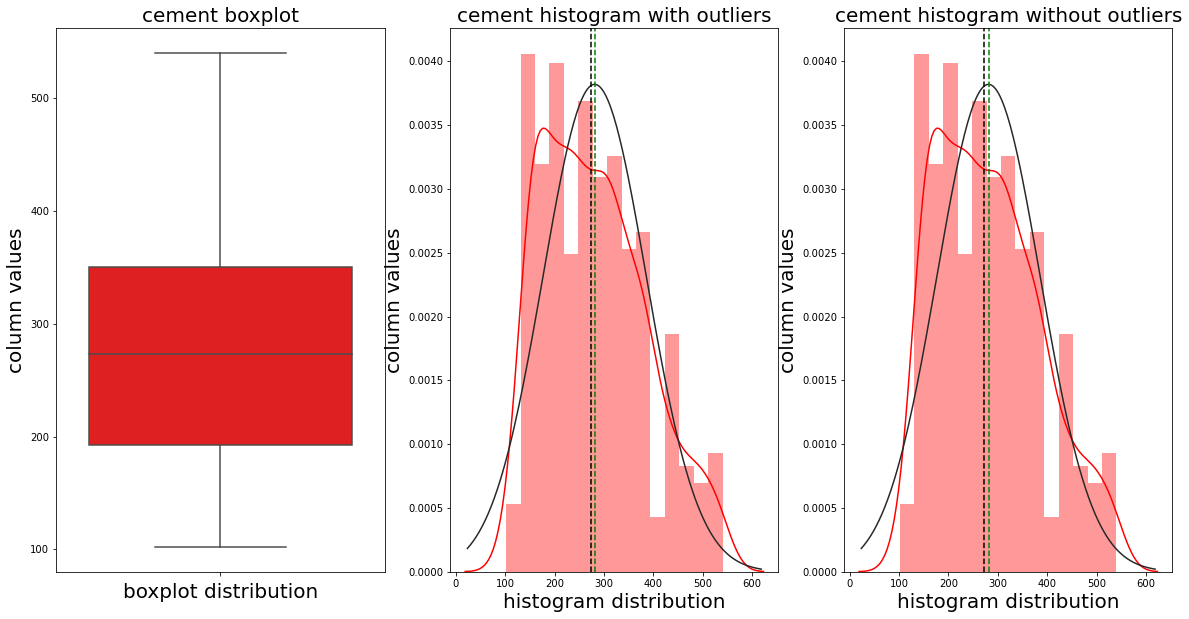

Replacing outliers for slag 

Total number of outliers are : 2 

Density of the outlier is : 0.19 

Outlier for slag are [359.4 359.4]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
918   239.6  359.4  0.0  185.7           0.0      941.6    664.3   28   
990   239.6  359.4  0.0  185.7           0.0      941.6    664.3    7   

     strength  
918     39.44  
990     25.42

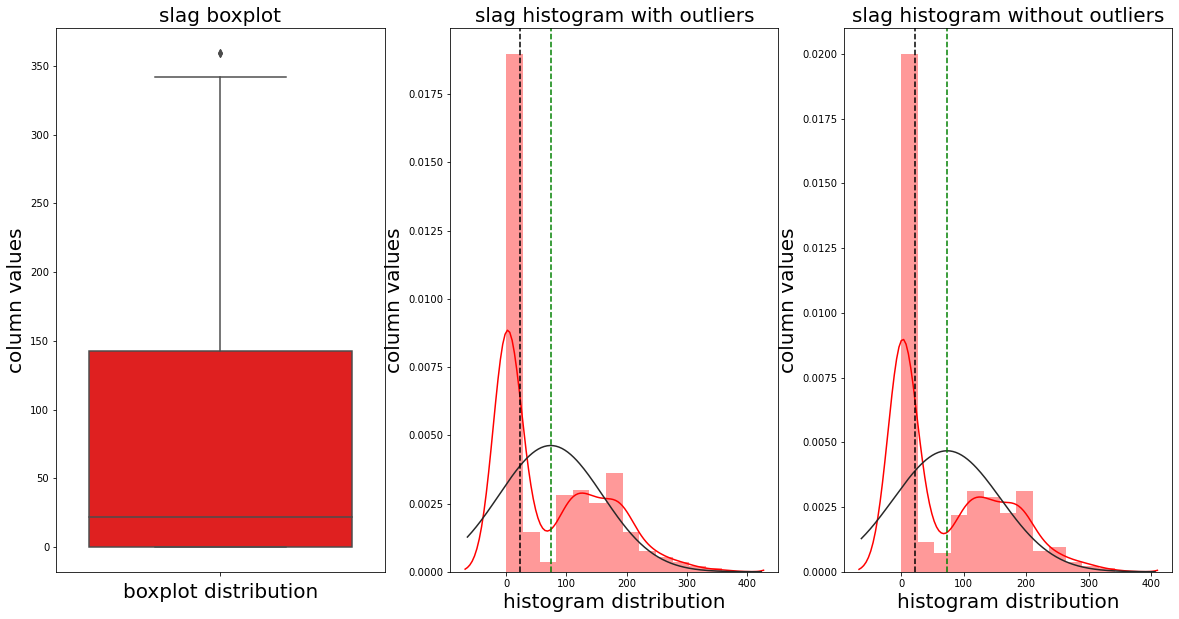

Feature ash does not have outliers 



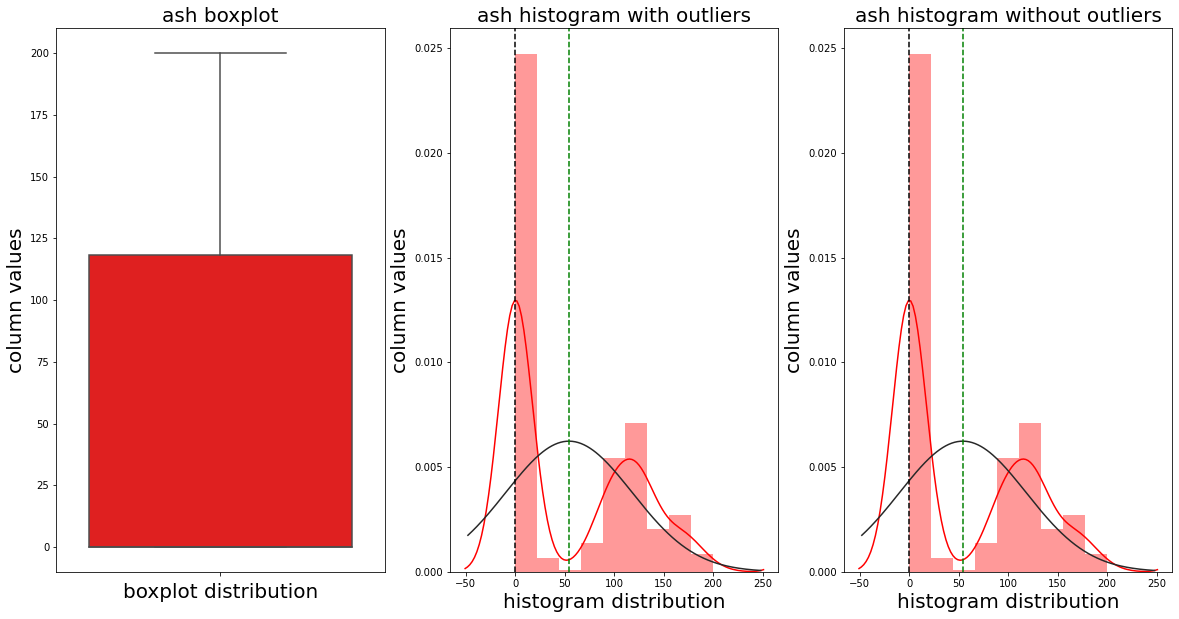

Replacing outliers for water 

Total number of outliers are : 9 

Density of the outlier is : 0.87 

Outlier for water are [121.8 121.8 121.8 121.8 121.8 236.7 237.  246.9 247. ]


cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
66    237.0   92.0   71.0  247.0           6.0      853.0    695.0   28   
263   236.9   91.7   71.5  246.9           6.0      852.9    695.4   28   
432   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   28   
462   168.0   42.1  163.8  121.8           5.7     1058.7    780.1  100   
587   168.0   42.1  163.8  121.8           5.7     1058.7    780.1    3   
740   140.0  164.0  128.0  237.0           6.0      869.0    656.0   28   
789   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   56   
826   139.7  163.9  127.7  236.7           5.8      868.6    655.6   28   
914   168.0   42.1  163.8  121.8           5.7     1058.7    780.1   14   

     strength  
66      28.63  
263     28.63  
432     24.24  
462     39.23  
587      7.75  
740     35.23  
789     32.85  
826     35.23  
914     17.82

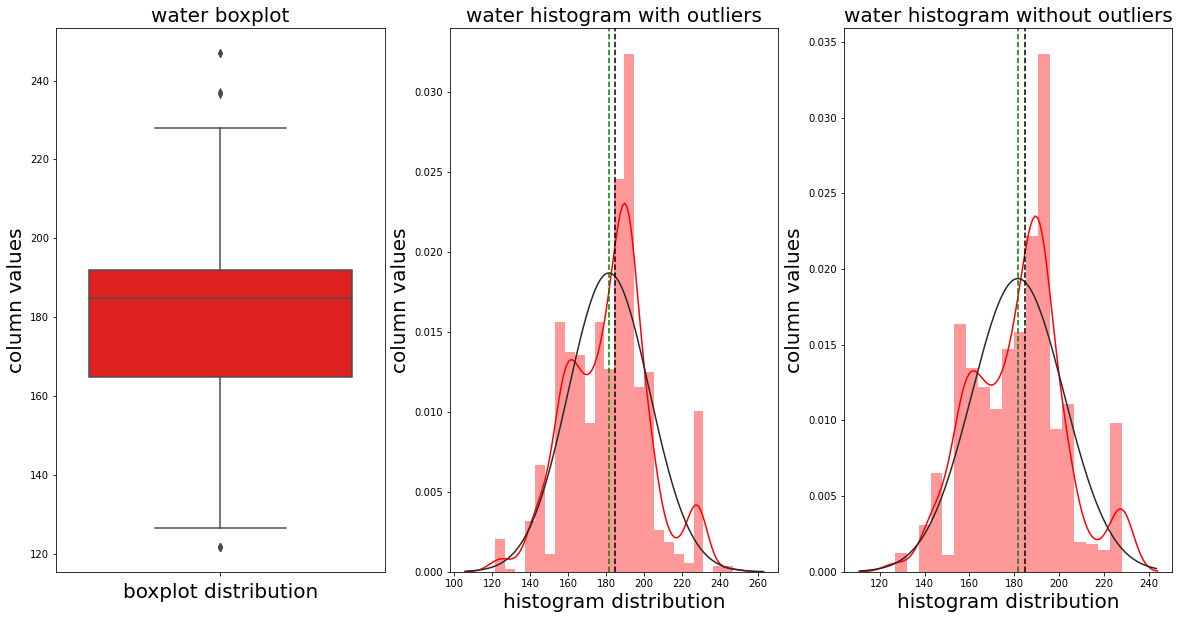

Replacing outliers for superplastic 

Total number of outliers are : 10 

Density of the outlier is : 0.97 

Outlier for superplastic are [28.2 28.2 28.2 28.2 28.2 32.2 32.2 32.2 32.2 32.2]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
44     531.3    0.0  0.0  141.8          28.2      852.1    893.7   91   
156    531.3    0.0  0.0  141.8          28.2      852.1    893.7   28   
232    469.0  117.2  0.0  137.8          32.2      852.1    840.5   56   
292    469.0  117.2  0.0  137.8          32.2      852.1    840.5   91   
538    531.3    0.0  0.0  141.8          28.2      852.1    893.7    7   
744    469.0  117.2  0.0  137.8          32.2      852.1    840.5    7   
816    469.0  117.2  0.0  137.8          32.2      852.1    840.5   28   
838    531.3    0.0  0.0  141.8          28.2      852.1    893.7   56   
955    469.0  117.2  0.0  137.8          32.2      852.1    840.5    3   
1026   531.3    0.0  0.0  141.8          28.2      852.1    893.7    3   

      strength  
44        59.2  
156       56.4  
232       69.3  
292       70.7  
538       46.9  
744       54.9  
816       66.9  
838       58.8  
955       40.2  
1026      41.3

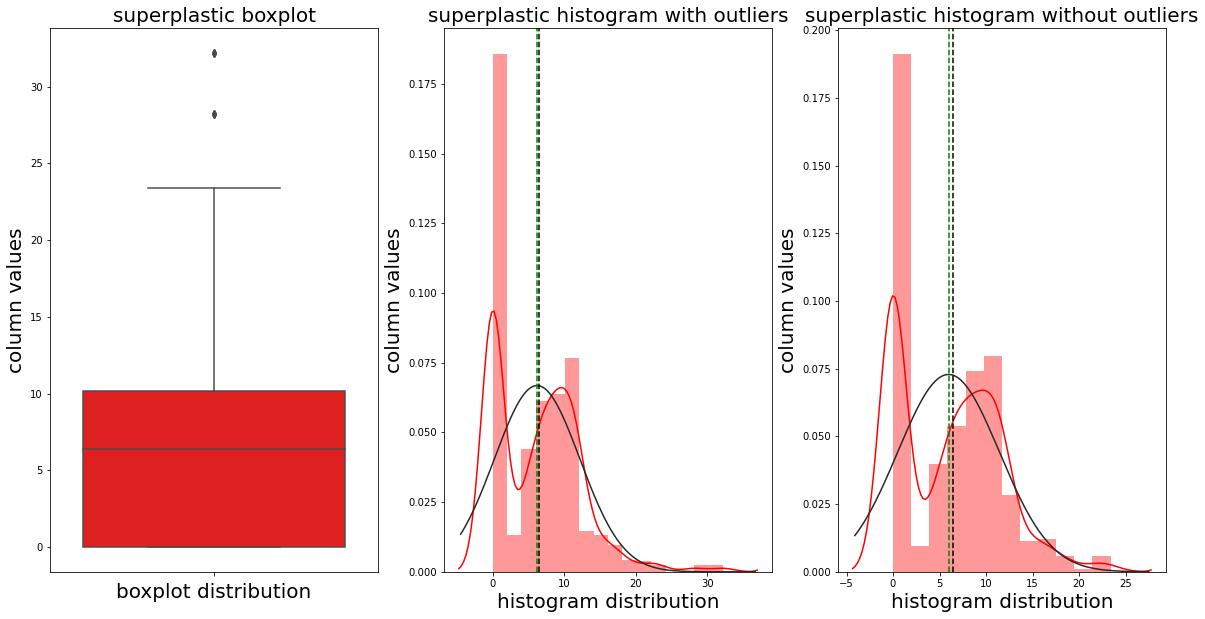

Feature coarseagg does not have outliers 



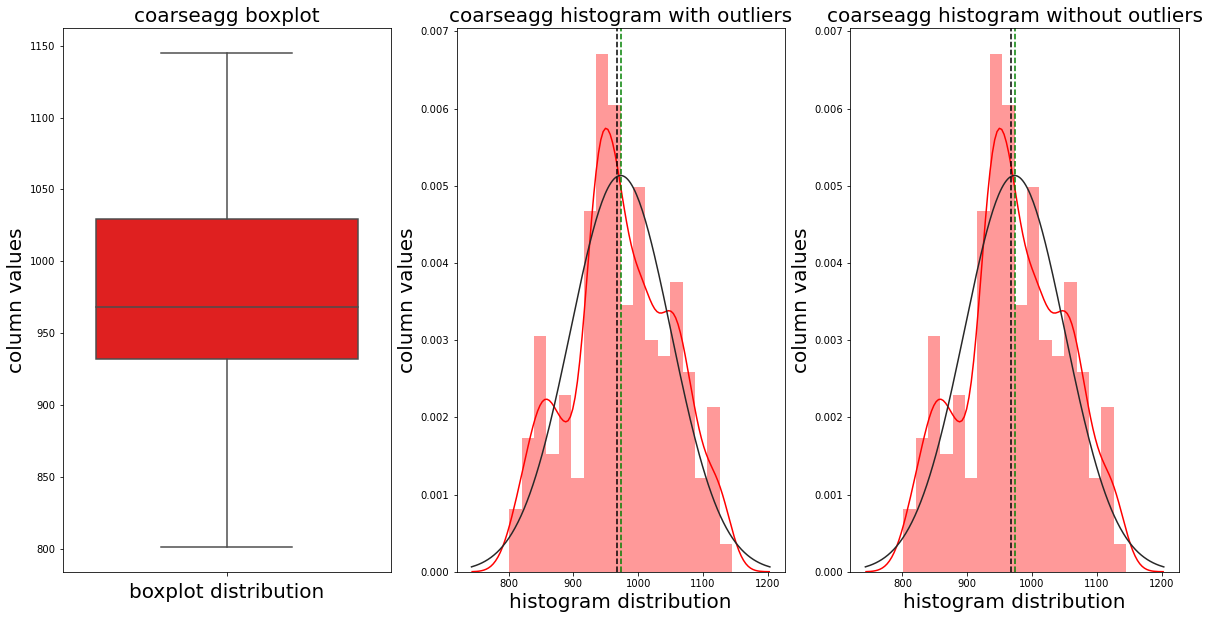

Replacing outliers for fineagg 

Total number of outliers are : 5 

Density of the outlier is : 0.49 

Outlier for fineagg are [992.6 992.6 992.6 992.6 992.6]


cement  slag  ash  water  superplastic  coarseagg  fineagg  age  strength
129   375.0  93.8  0.0  126.6          23.4      852.1    992.6   91      62.5
447   375.0  93.8  0.0  126.6          23.4      852.1    992.6    7      45.7
504   375.0  93.8  0.0  126.6          23.4      852.1    992.6    3      29.0
584   375.0  93.8  0.0  126.6          23.4      852.1    992.6   56      60.2
857   375.0  93.8  0.0  126.6          23.4      852.1    992.6   28      56.7

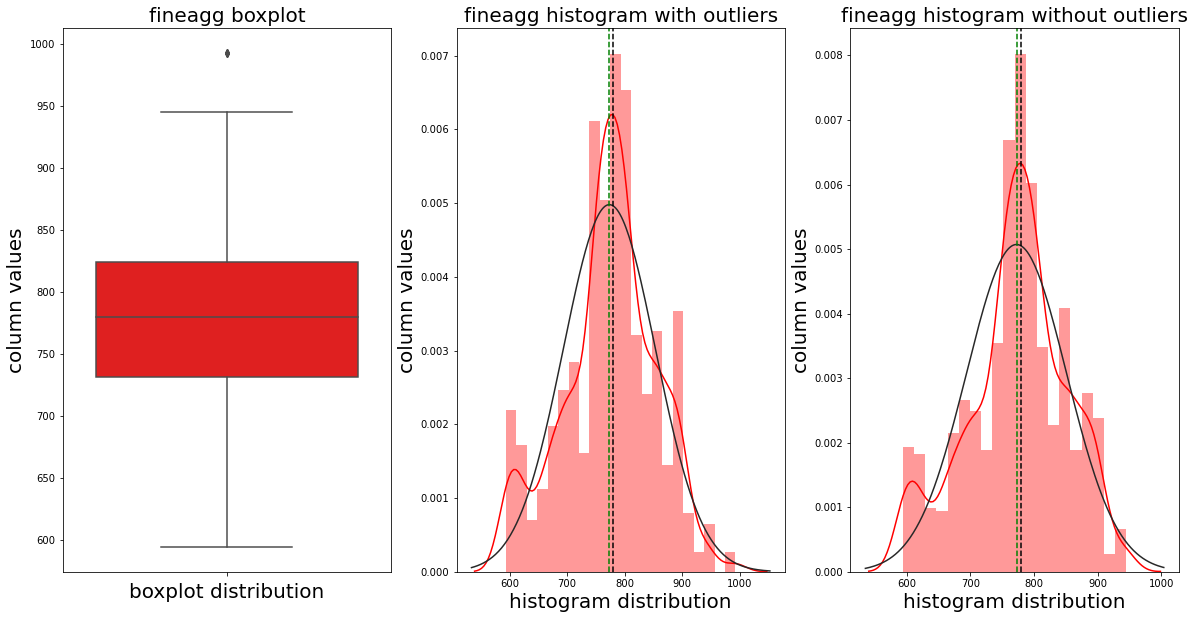

Replacing outliers for age 

Total number of outliers are : 59 

Density of the outlier is : 5.73 

Outlier for age are [180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 270 270 270 270 270 270 270 270 270 270
 270 270 270 360 360 360 360 360 360 365 365 365 365 365 365 365 365 365
 365 365 365 365 365]


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
51     331.0    0.0  0.0  192.0           0.0      978.0    825.0  180   
64     332.5  142.5  0.0  228.0           0.0      932.0    594.0  365   
93     427.5   47.5  0.0  228.0           0.0      932.0    594.0  180   
99     237.5  237.5  0.0  228.0           0.0      932.0    594.0  180   
103    380.0    0.0  0.0  228.0           0.0      932.0    670.0  180   
133    236.0    0.0  0.0  193.0           0.0      968.0    885.0  365   
144    302.0    0.0  0.0  203.0           0.0      974.0    817.0  180   
149    380.0   95.0  0.0  228.0           0.0      932.0    594.0  270   
152    322.0    0.0  0.0  203.0           0.0      974.0    800.0  180   
157    198.6  132.4  0.0  192.0           0.0      978.4    825.5  360   
159    304.0   76.0  0.0  228.0           0.0      932.0    670.0  365   
198    266.0  114.0  0.0  228.0           0.0      932.0    670.0  365   
199    277.0    0.0  0.0  191.0           0.0      968.0    856.0  180   
207    190.0  190.0  0.0  228.0           0.0      932.0    670.0  180   
256    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  270   
262    266.0  114.0  0.0  228.0           0.0      932.0    670.0  270   
270    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  270   
297    475.0    0.0  0.0  228.0           0.0      932.0    594.0  270   
302    342.0   38.0  0.0  228.0           0.0      932.0    670.0  180   
312    236.0    0.0  0.0  193.0           0.0      968.0    885.0  180   
313    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  270   
323    139.6  209.4  0.0  192.0           0.0     1047.0    806.9  360   
359    475.0    0.0  0.0  228.0           0.0      932.0    594.0  180   
361    277.0    0.0  0.0  191.0           0.0      968.0    856.0  360   
370    266.0  114.0  0.0  228.0           0.0      932.0    670.0  180   
393    342.0   38.0  0.0  228.0           0.0      932.0    670.0  365   
448    331.0    0.0  0.0  192.0           0.0      978.0    825.0  360   
465    427.5   47.5  0.0  228.0           0.0      932.0    594.0  365   
484    237.5  237.5  0.0  228.0           0.0      932.0    594.0  365   
539    304.0   76.0  0.0  228.0           0.0      932.0    670.0  180   
570    190.0  190.0  0.0  228.0           0.0      932.0    670.0  270   
581    525.0    0.0  0.0  189.0           0.0     1125.0    613.0  180   
594    339.0    0.0  0.0  197.0           0.0      968.0    781.0  180   
601    339.0    0.0  0.0  197.0           0.0      968.0    781.0  365   
620    332.5  142.5  0.0  228.0           0.0      932.0    594.0  180   
622    380.0   95.0  0.0  228.0           0.0      932.0    594.0  180   
623    380.0    0.0  0.0  228.0           0.0      932.0    670.0  270   
632    304.0   76.0  0.0  228.0           0.0      932.0    670.0  270   
642    198.6  132.4  0.0  192.0           0.0      978.4    825.5  180   
696    307.0    0.0  0.0  193.0           0.0      968.0    812.0  180   
713    190.0  190.0  0.0  228.0           0.0      932.0    670.0  365   
720    380.0   95.0  0.0  228.0           0.0      932.0    594.0  365   
721    500.0    0.0  0.0  200.0           0.0     1125.0    613.0  180   
754    254.0    0.0  0.0  198.0           0.0      968.0    863.0  365   
755    349.0    0.0  0.0  192.0           0.0     1047.0    806.0  360   
776    540.0    0.0  0.0  173.0           0.0     1125.0    613.0  180   
850    427.5   47.5  0.0  228.0           0.0      932.0    594.0  270   
861    310.0    0.0  0.0  192.0           0.0      970.0    850.0  180   
878    237.5  237.5  0.0  228.0           0.0      932.0    594.0  270   
900    254.0    0.0  0.0  198.0           0.0      968.0    863.0  180   
901    475.0    0.0  0.0  228.0           0.0      932.0    594.0  365   
919    310.0    0.0  0.0  192.0           0.0      970.0    850.0  360   
951    332.5  142.5  0.0  228.0           0.0      932.0    594.0  270   
957    307

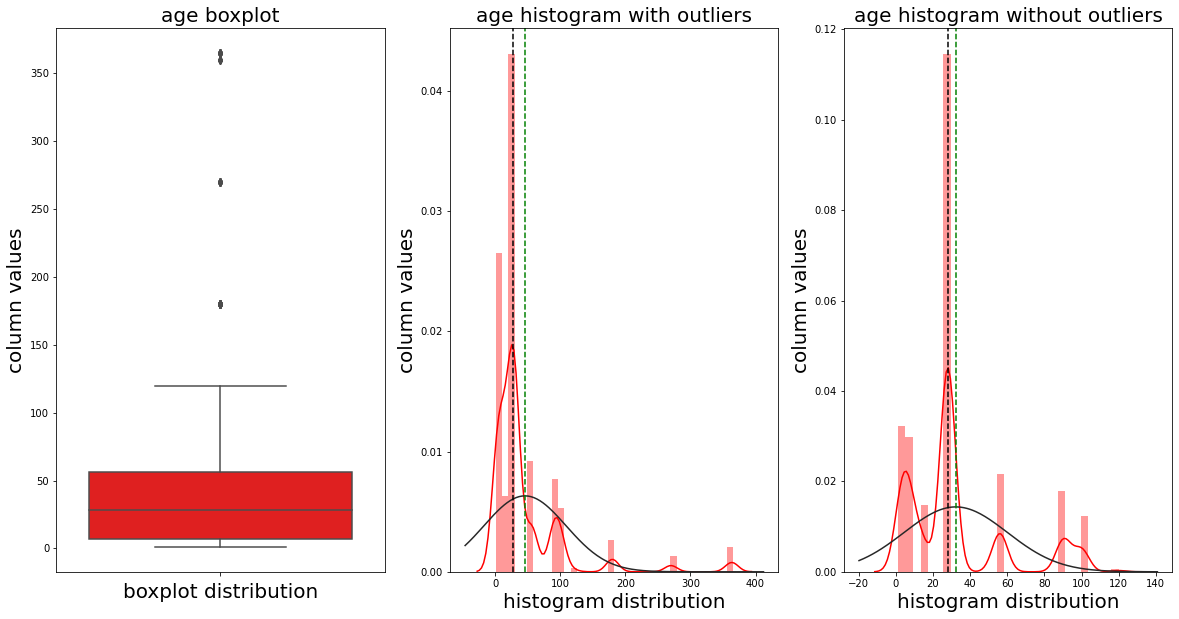

Replacing outliers for strength 

Total number of outliers are : 4 

Density of the outlier is : 0.39 

Outlier for strength are [79.99 80.2  81.75 82.6 ]


cement   slag  ash  water  superplastic  coarseagg  fineagg   age  \
192    315.0  137.0  0.0  145.0           5.9     1130.0    745.0  28.0   
732    540.0    0.0  0.0  162.0           2.5     1040.0    676.0  28.0   
950    389.9  189.0  0.0  145.9          22.0      944.7    755.8  91.0   
1003   323.7  282.8  0.0  183.8          10.3      942.7    659.9  56.0   

      strength  
192      81.75  
732      79.99  
950      82.60  
1003     80.20

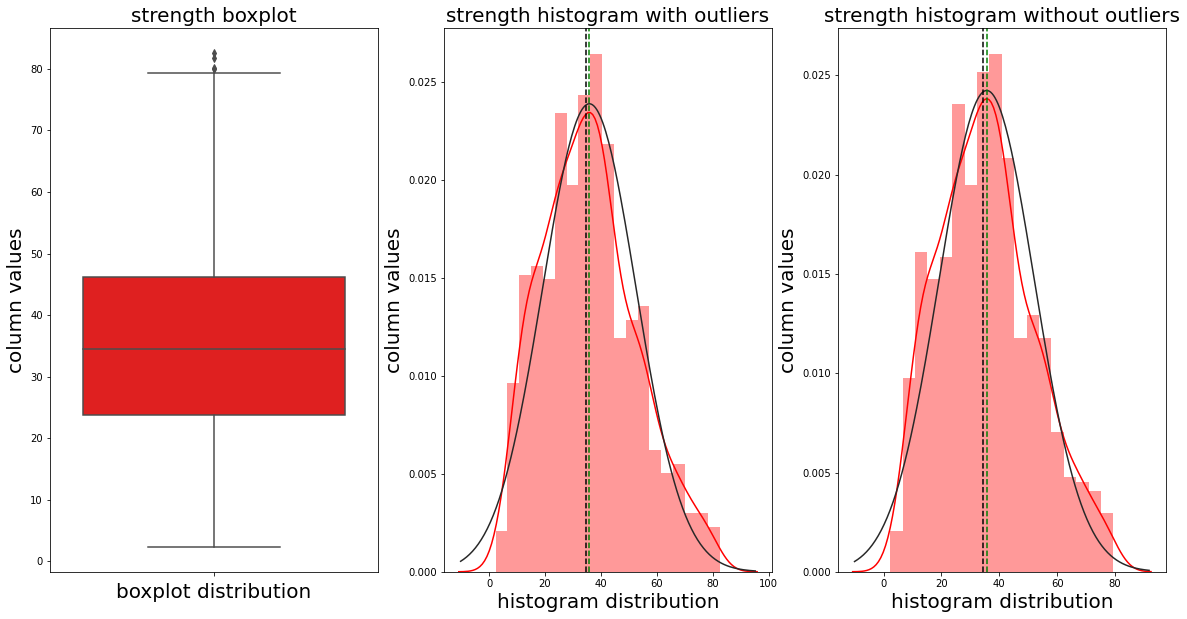

In [10]:
for col in list(df.columns):
    odtPlot(df,col)

Outlier Treatment

In [11]:
def outlier_treatment(df,col,method='quartile',strategy='median'):
    col_data = df[col]
    q1,q2,q3 = col_data.quantile([0.25,0.5,0.75])
    col_mean = col_data.mean()
    col_median = q2
    col_stdev = col_data.std()
    
    
    #certain outlier boundaries using quantile number
    if method =='quartile':
        IQR = q3-q1
        upper_limit = q3+1.5*IQR
        lower_limit = q1-1.5*IQR
    
    #setting outlier boundary using STD method
    elif method =='stdev':
        cut_off = col_stdev*2
        lower_limit = col_mean-cut_off
        upper_limit = col_mean+cut_off
    else:
        print('Error, please pass the correct method')
        
        
        
    #Printing outliers
    outliers = df.loc[(col_data < lower_limit) | (col_data > upper_limit), col]
    outlier_density = round((len(outliers)/len(df))*100,2)
    if len(outliers) != 0:
        print(f'Feature{col} does not have outliers')
    else:
        print(f'total number of outliers are :{len(outliers)} \n')
        print(f'Density of the outlier is :{outlier_density} \n')
        print(f'Outlier for {col} are {np.sort(np.array(outliers))}')
        display(df[(col_data < lower_limit) | (col_data > upper_limit)])
              
    # Replacing outliers with mean od median
    if strategy =='median':
              df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = col_median
    elif strategy == 'mean':
              df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = col_mean
    else:
        print('Error, please pass the correct strategy')
              
    return df

In [12]:
for col in list(df.columns):
    outlier_treatment(df,col)

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for cement are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for slag are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for ash are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for water are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for superplastic are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

total number of outliers are :0 

Density of the outlier is :0.0 

Outlier for coarseagg are []


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

Featurefineagg does not have outliers
Featureage does not have outliers
Featurestrength does not have outliers


Custom summary of treated data 

In [13]:
CustomSummary(df)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   85.38   7290.50    0.00    0.00   73.24   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   20.60    424.49  126.60  164.90  181.65   
superplastic   1030  float64    5.48     30.00    0.00    0.00    5.97   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   72.37   5236.97  605.00  745.00  777.95   
age            1030  float64   14.14    199.93    1.00    7.00   23.76   
strength       1030  float64   16.18    261.76    2.33   23.71   35.42   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.73   342.1  342.10  142.73     -0.62      0.78   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   228.0  101.40   27.10     -0.04      0.09   
superplastic    6.40    10.07    23.4   23.40   10.07     -0.44      0.47   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.45   822.20   945.0  340.00   77.20     -0.12     -0.21   
age            28.00    28.00    56.0   55.00   21.00      0.28      0.42   
strength       34.41    45.30    78.8   76.47   21.59     -0.41      0.35   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     No Outliers  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     No Outliers  
superplastic   Fairly Symmetric(Positive)     No Outliers  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age            Fairly Symmetric(Positive)     No Outliers  
strength       Fairly Symmetric(Positive)     No Outliers

In [14]:
CustomSummary(df2)

Count Datatype      SD       Var     Min      Q1    Mean  \
FeatureName                                                              
cement         1030  float64  104.51  10921.58  102.00  192.38  281.17   
slag           1030  float64   86.28   7444.12    0.00    0.00   73.90   
ash            1030  float64   64.00   4095.62    0.00    0.00   54.19   
water          1030  float64   21.35    456.00  121.80  164.90  181.57   
superplastic   1030  float64    5.97     35.69    0.00    0.00    6.20   
coarseagg      1030  float64   77.75   6045.68  801.00  932.00  972.92   
fineagg        1030  float64   80.18   6428.19  594.00  730.95  773.58   
age            1030    int64   63.17   3990.44    1.00    7.00   45.66   
strength       1030  float64   16.71    279.08    2.33   23.71   35.82   

              Median       Q3     Max   Range     IQR  Kurtosis  Skewness  \
FeatureName                                                                 
cement        272.90   350.00   540.0  438.00  157.62     -0.52      0.51   
slag           22.00   142.95   359.4  359.40  142.95     -0.51      0.80   
ash             0.00   118.30   200.1  200.10  118.30     -1.33      0.54   
water         185.00   192.00   247.0  125.20   27.10      0.12      0.07   
superplastic    6.40    10.20    32.2   32.20   10.20      1.41      0.91   
coarseagg     968.00  1029.40  1145.0  344.00   97.40     -0.60     -0.04   
fineagg       779.50   824.00   992.6  398.60   93.05     -0.10     -0.25   
age            28.00    56.00   365.0  364.00   49.00     12.17      3.27   
strength       34.44    46.14    82.6   80.27   22.43     -0.31      0.42   

                         Skewness Comment Outlier Comment  
FeatureName                                                
cement        Moderatey Positively Skewed     No Outliers  
slag          Moderatey Positively Skewed     Has Outlier  
ash           Moderatey Positively Skewed     No Outliers  
water          Fairly Symmetric(Positive)     Has Outlier  
superplastic  Moderatey Positively Skewed     Has Outlier  
coarseagg      Fairly Symmetric(Negative)     No Outliers  
fineagg        Fairly Symmetric(Negative)     Has Outlier  
age              Highly Positively Skewed     Has Outlier  
strength       Fairly Symmetric(Positive)     Has Outlier

In [15]:
x = df.drop('strength',axis=1)

In [16]:
y = df[['strength']]

In [17]:
x.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5  28.0
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2  14.0
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2  28.0
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0  28.0
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7  28.0

In [18]:
y.head()

strength
0     29.89
1     23.51
2     29.22
3     45.85
4     18.29

Feature Interaction

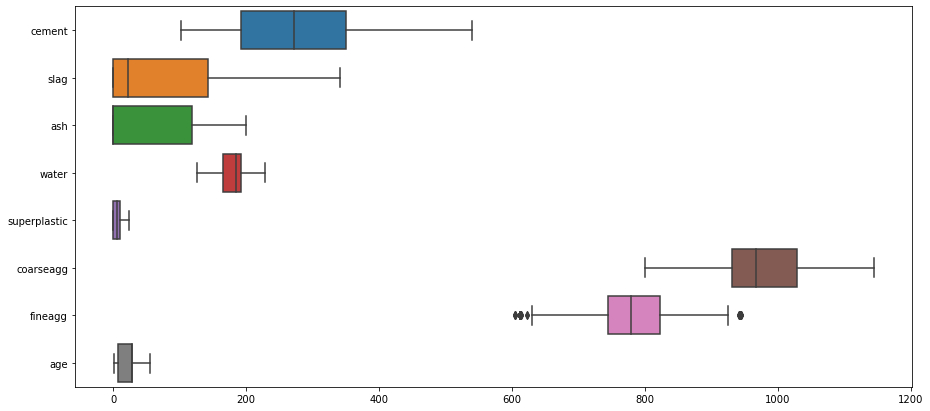

In [19]:
fig = plt.figure(figsize=(15,7))
ax = sns.boxplot(data=x, orient='h')

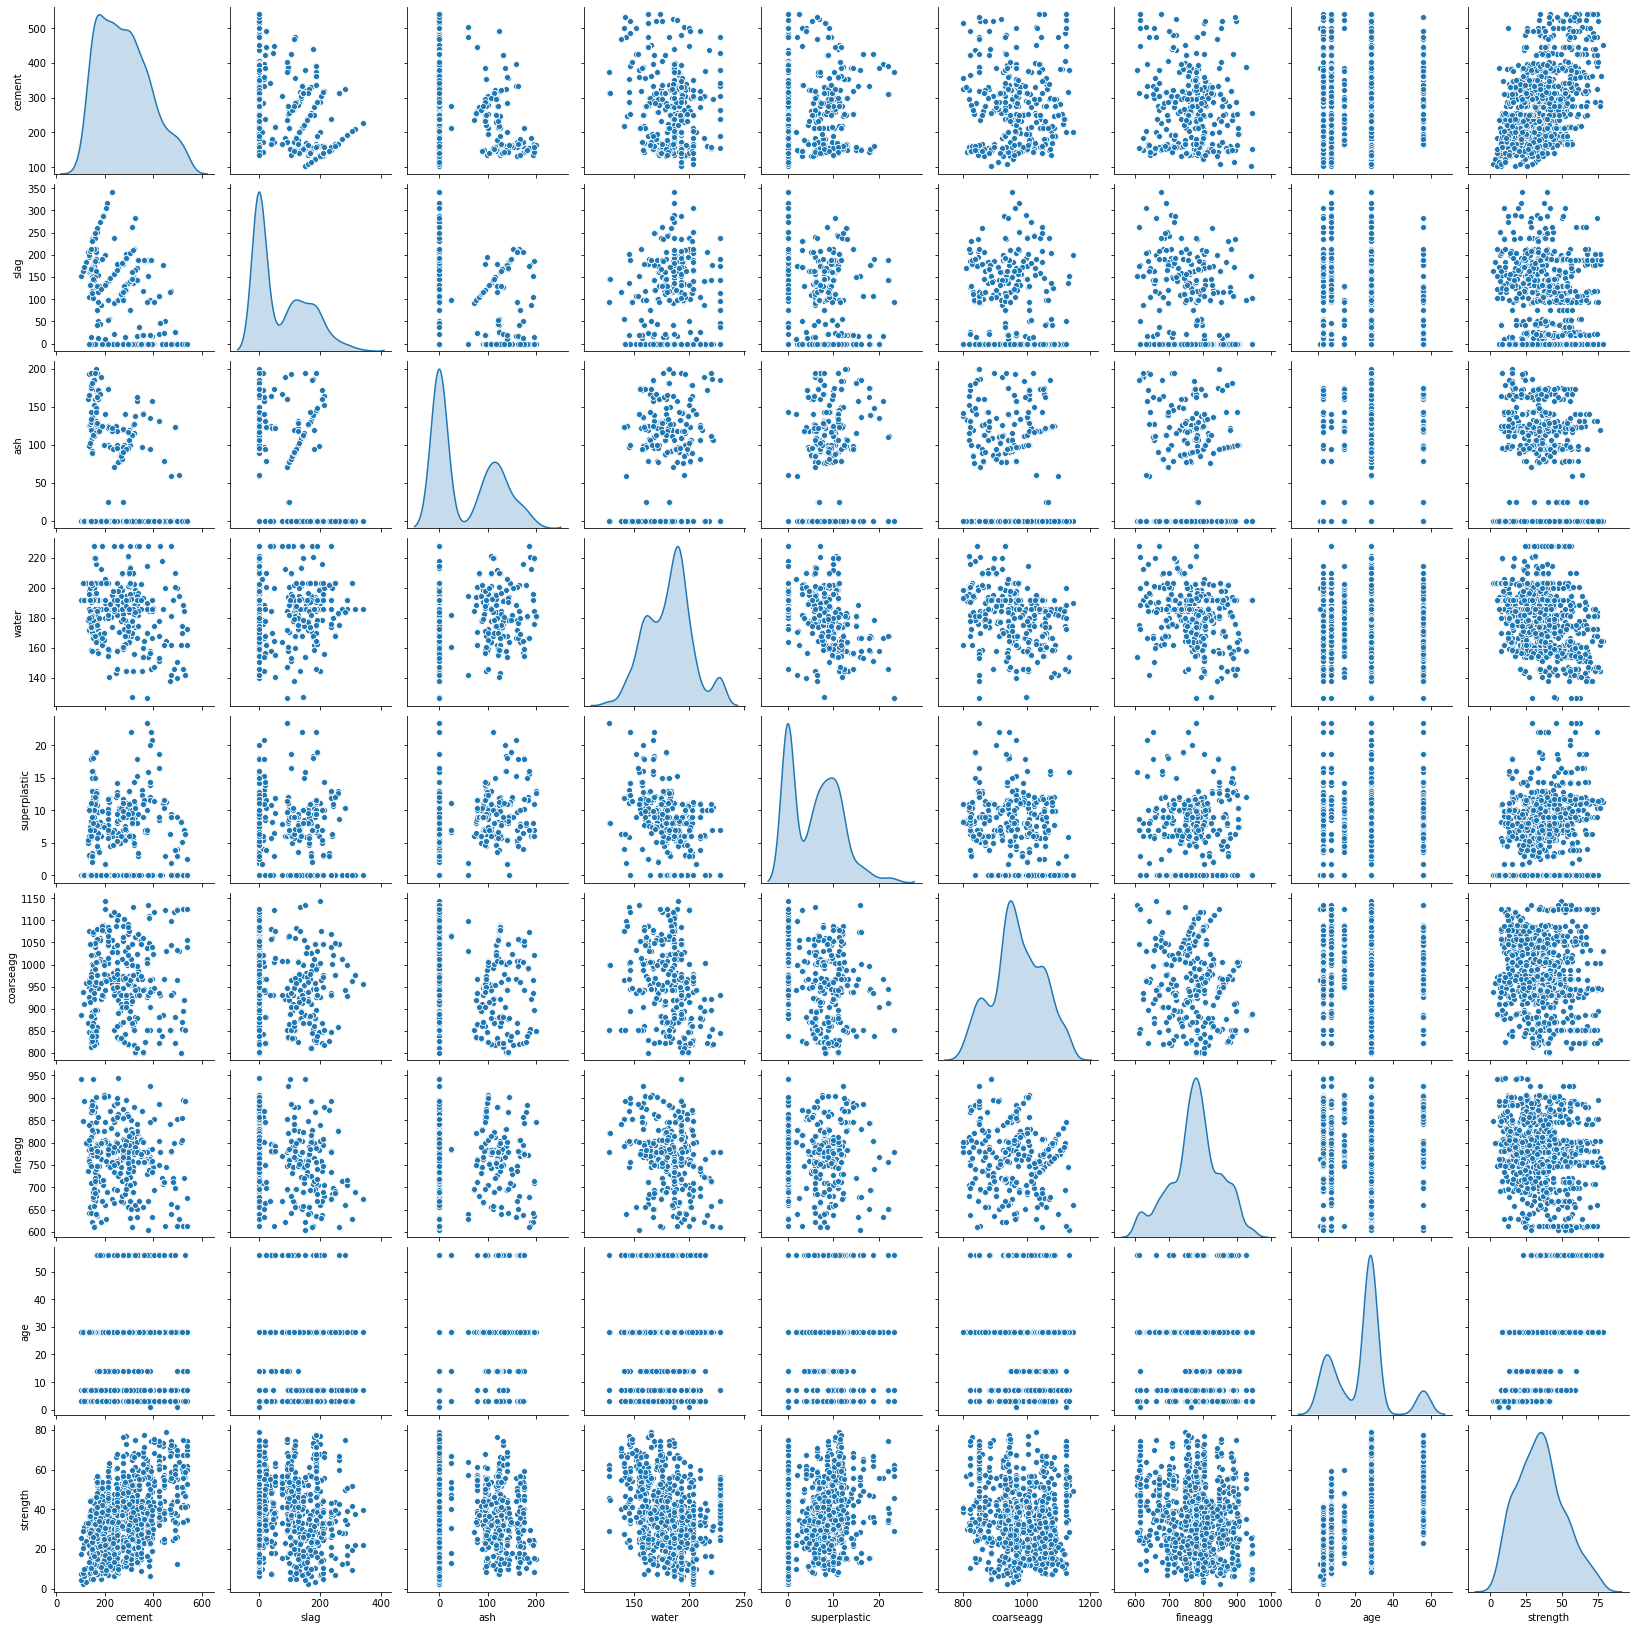

In [20]:
# Feature Interaction using pair plots
sns.pairplot(df,diag_kind='kde')

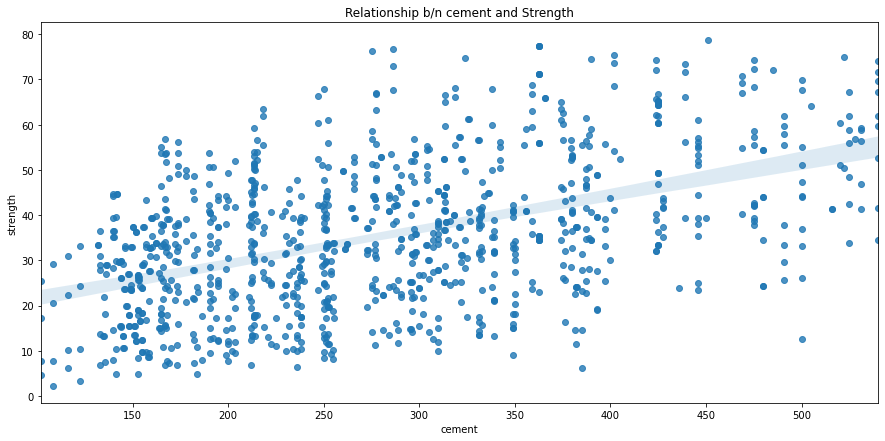

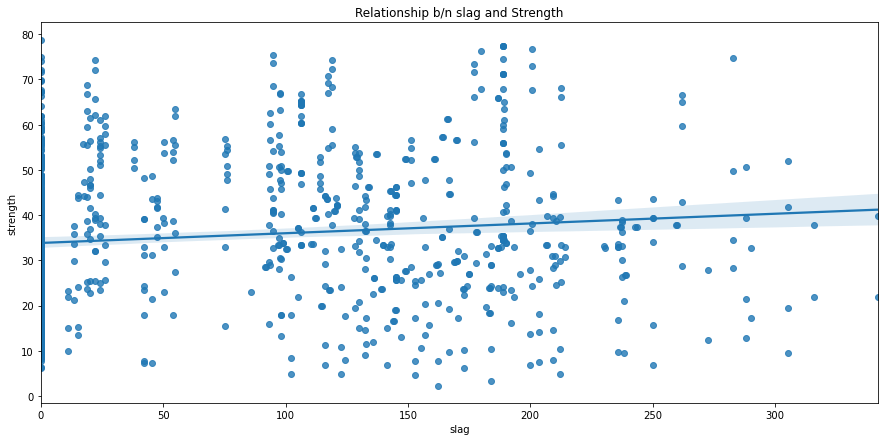

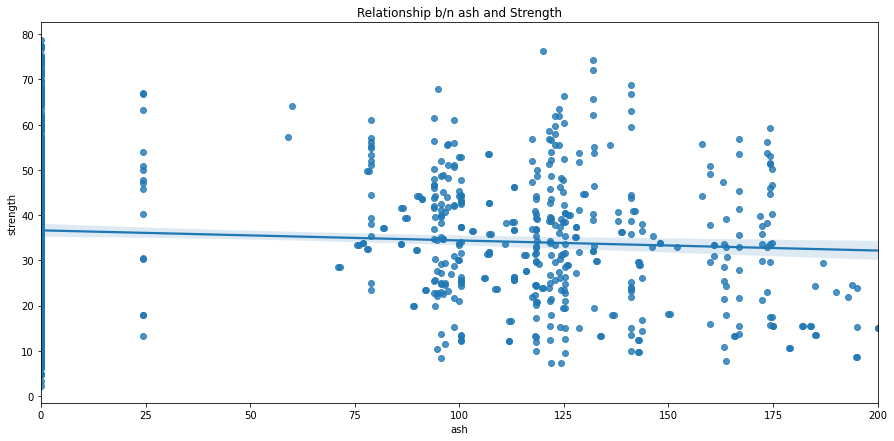

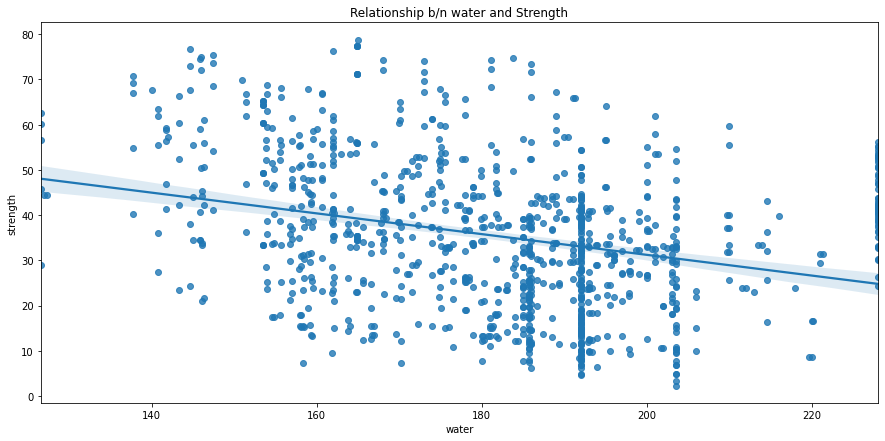

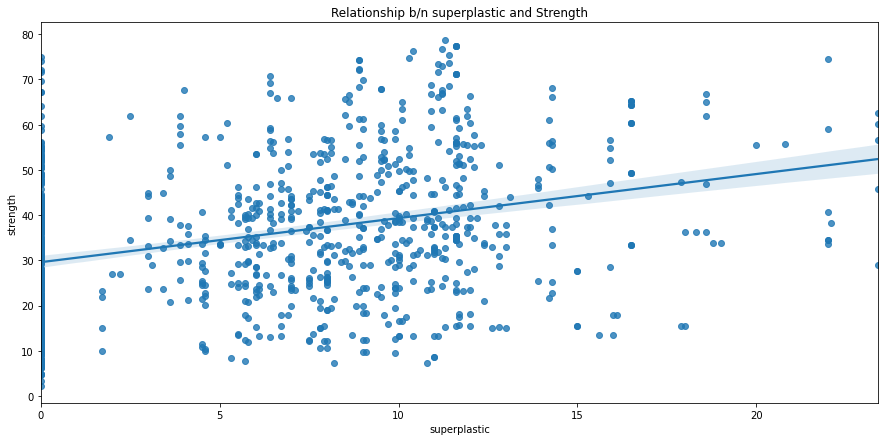

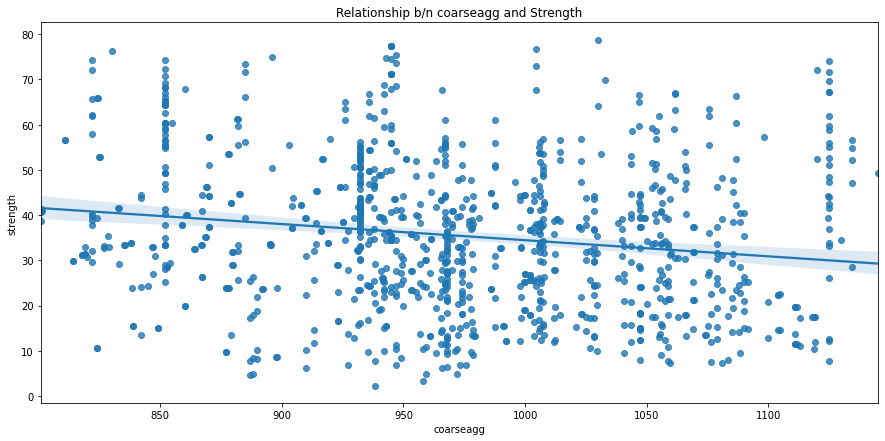

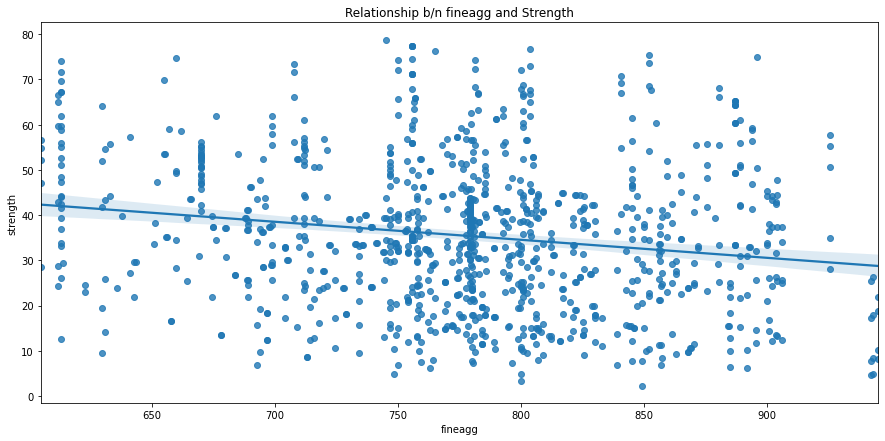

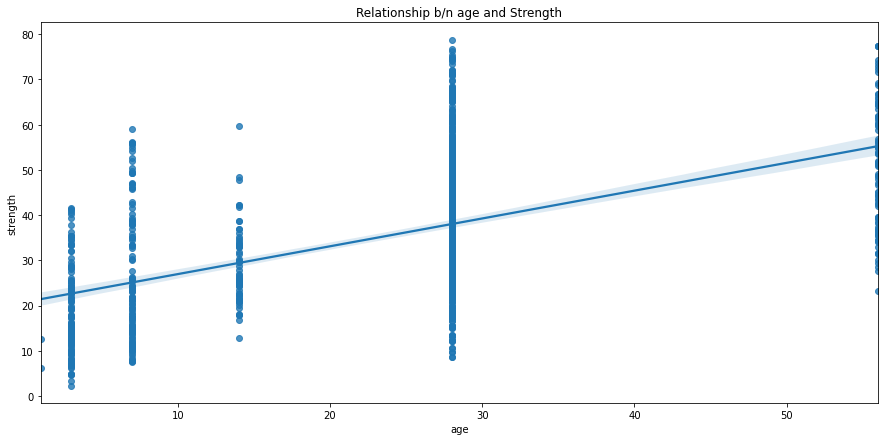

In [21]:
# Multivariet Analysis
for col in list(df.columns):
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize=(15,7),sharex=False)
        sns.regplot(x=df[col],y=df['strength'],ax=ax1).set_title(f'Relationship b/n {col} and Strength')

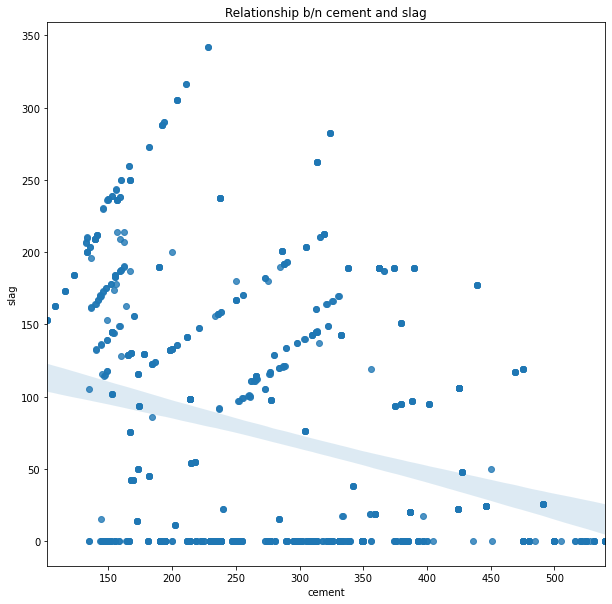

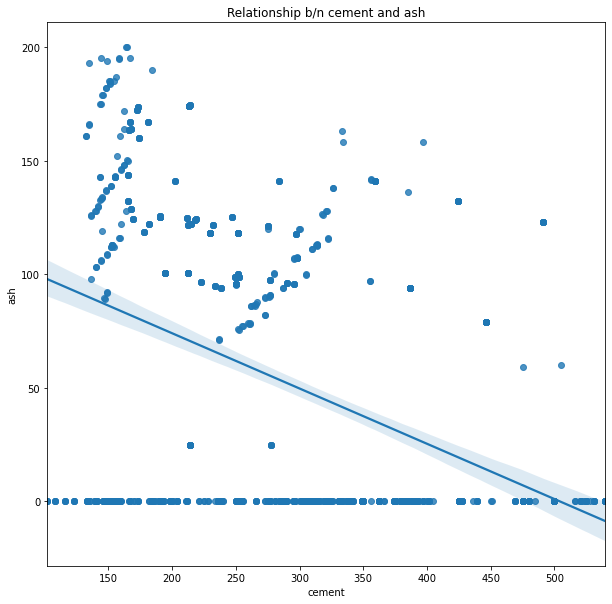

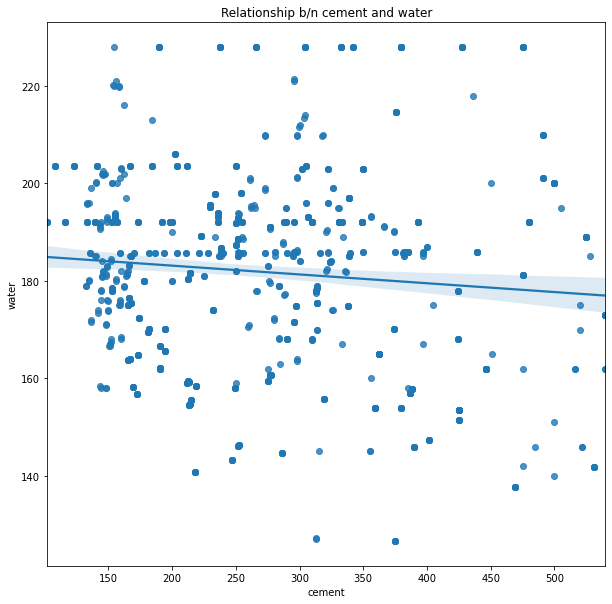

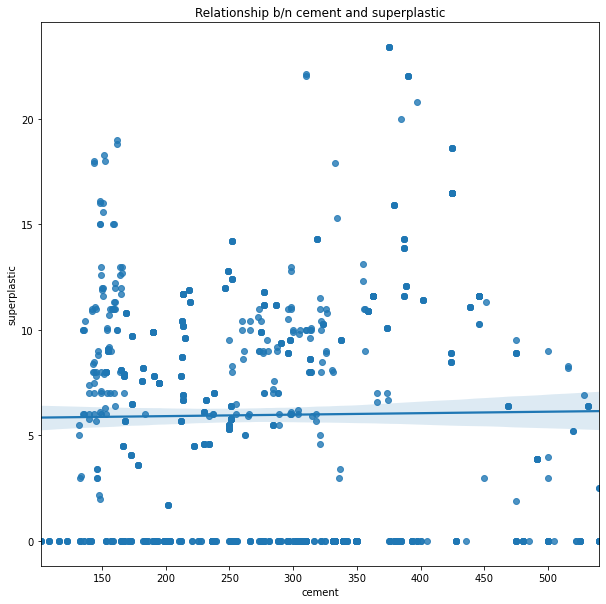

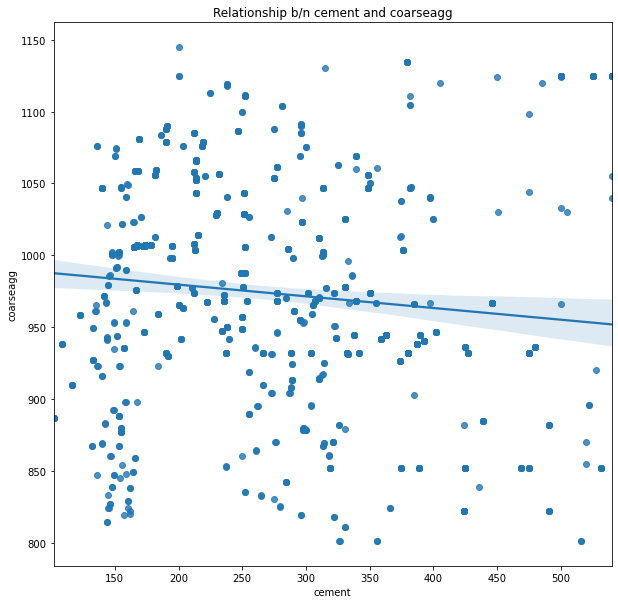

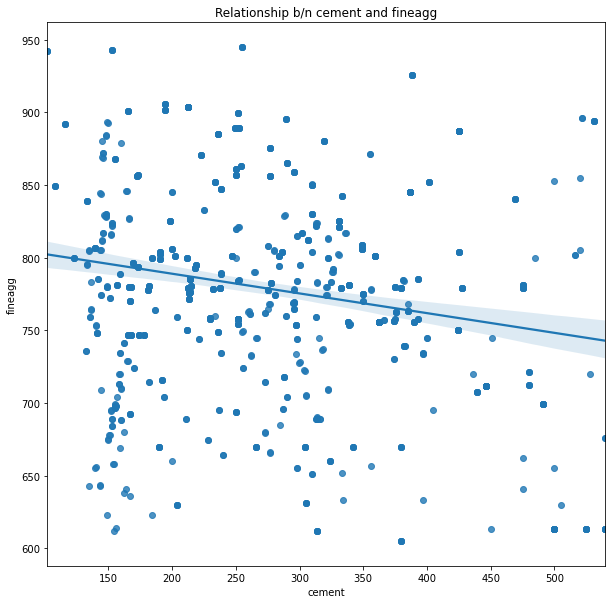

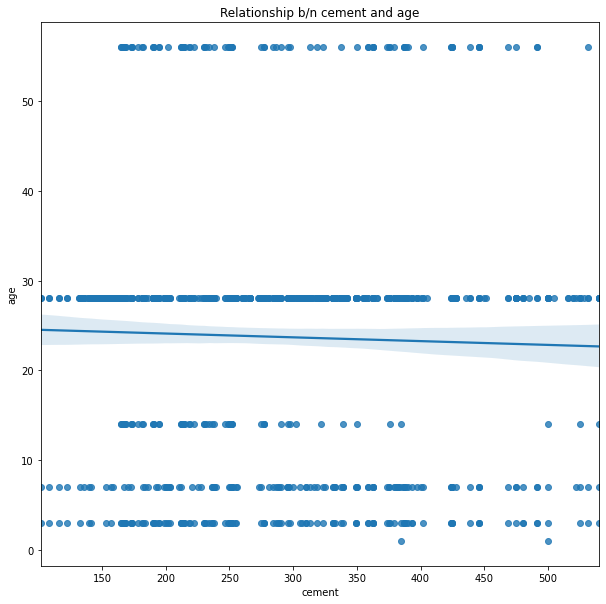

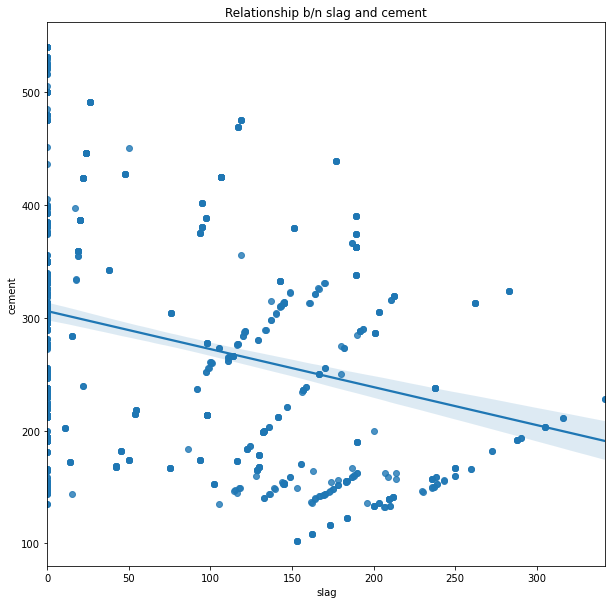

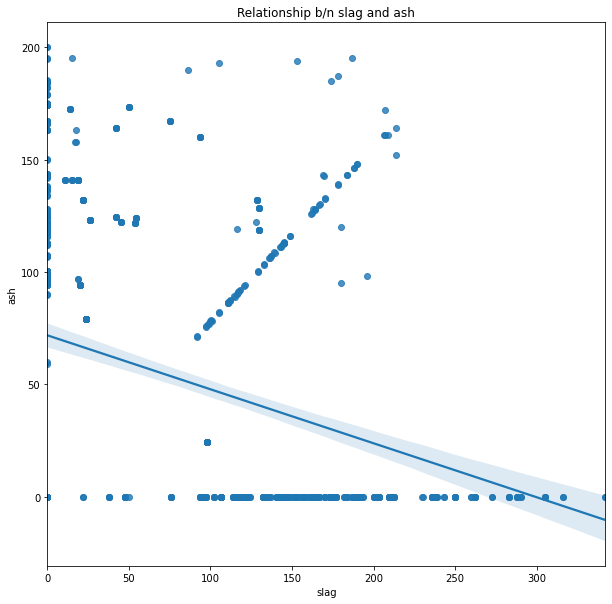

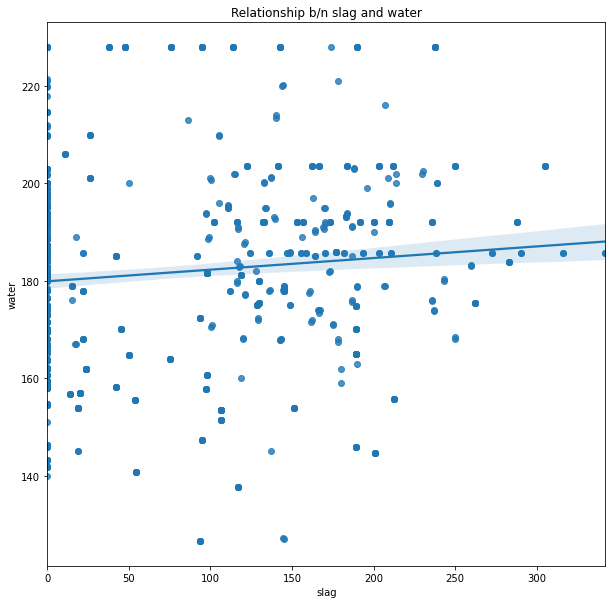

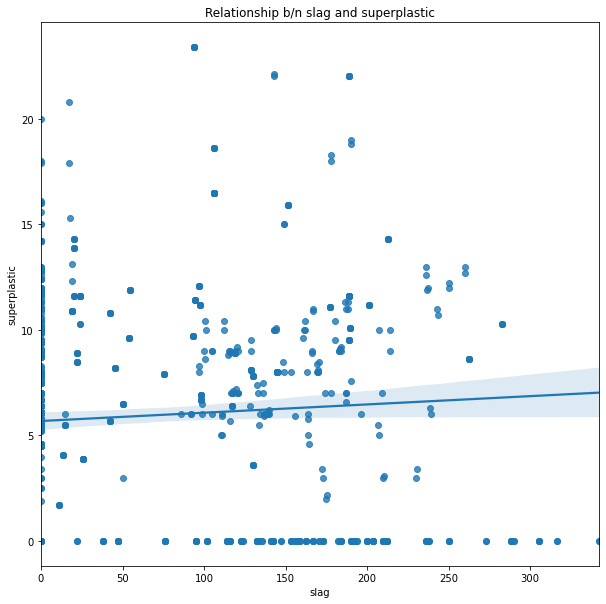

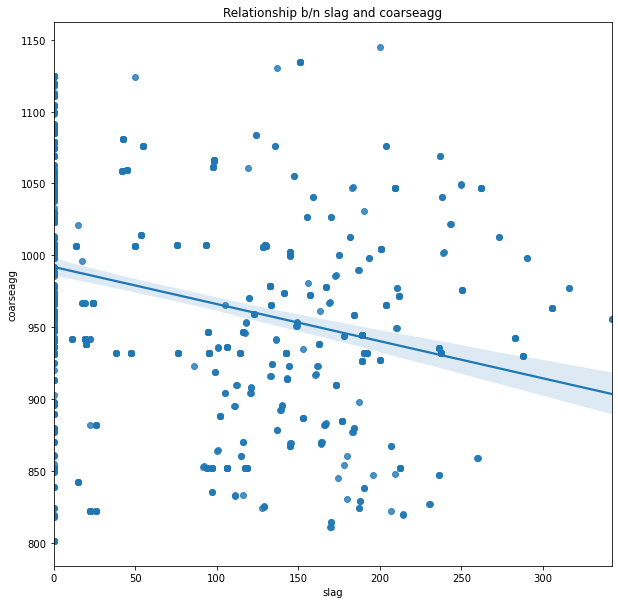

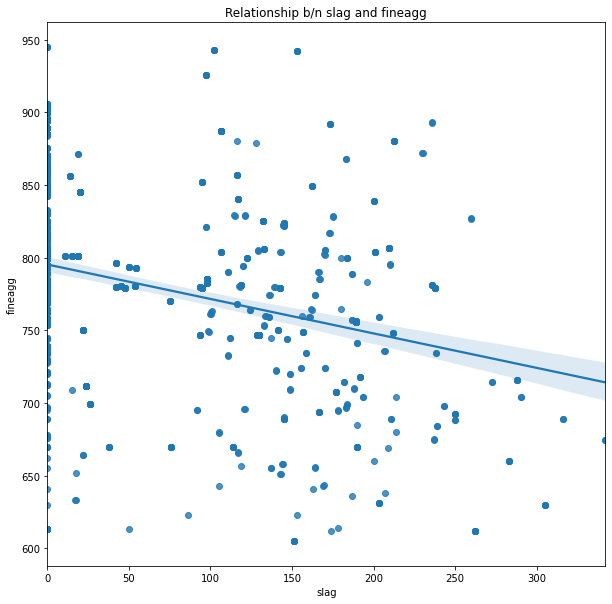

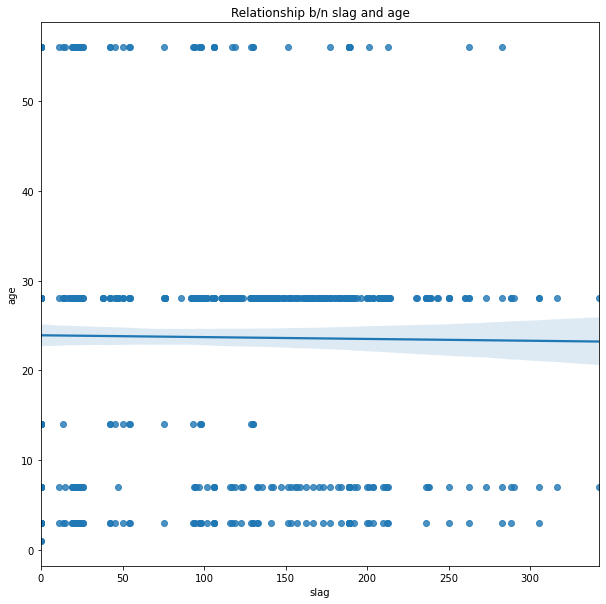

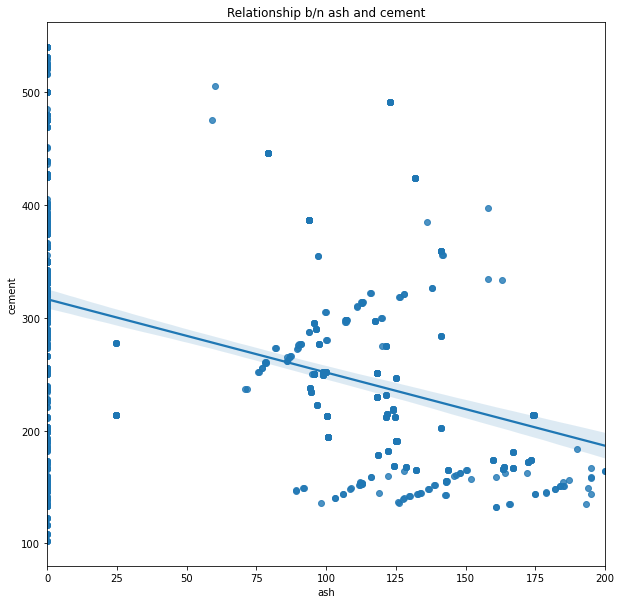

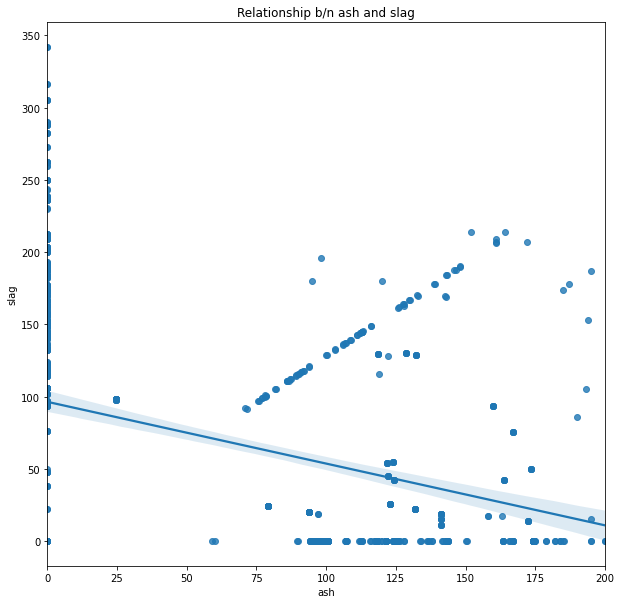

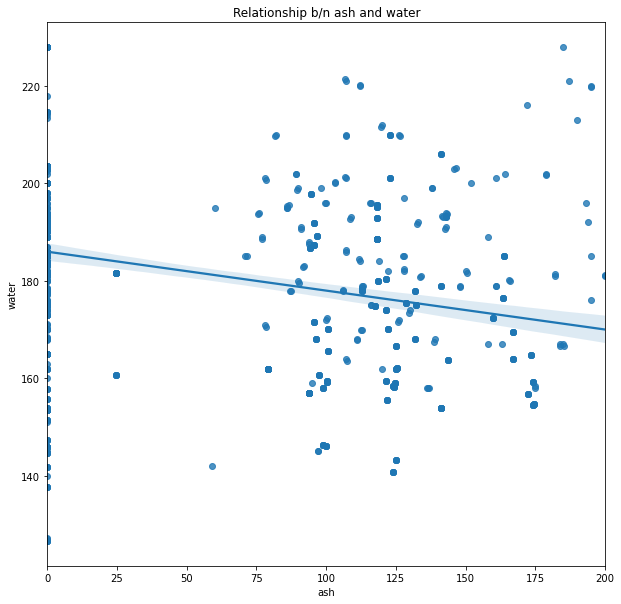

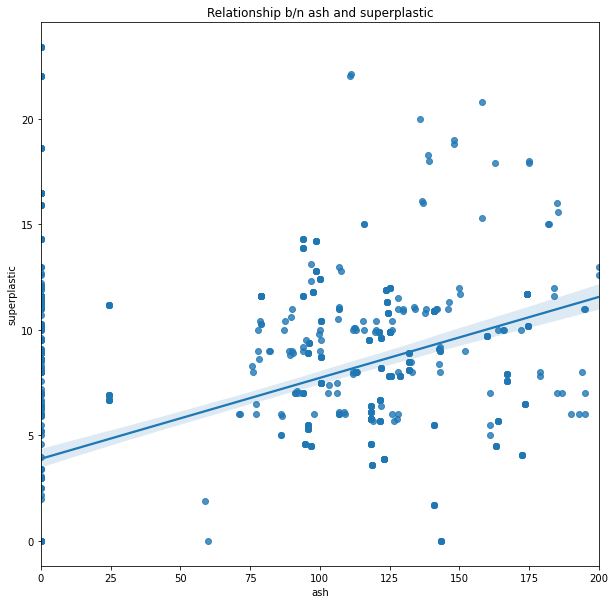

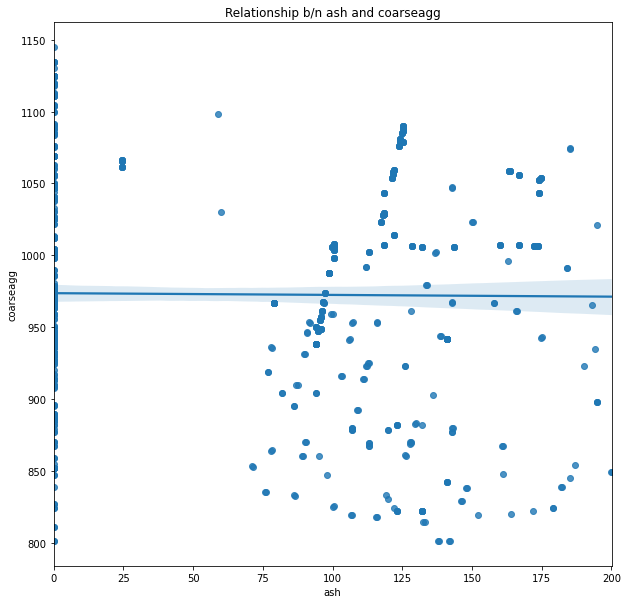

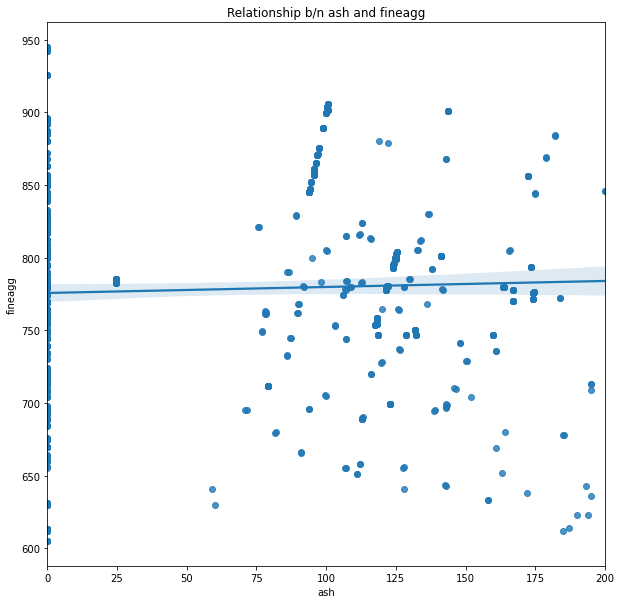

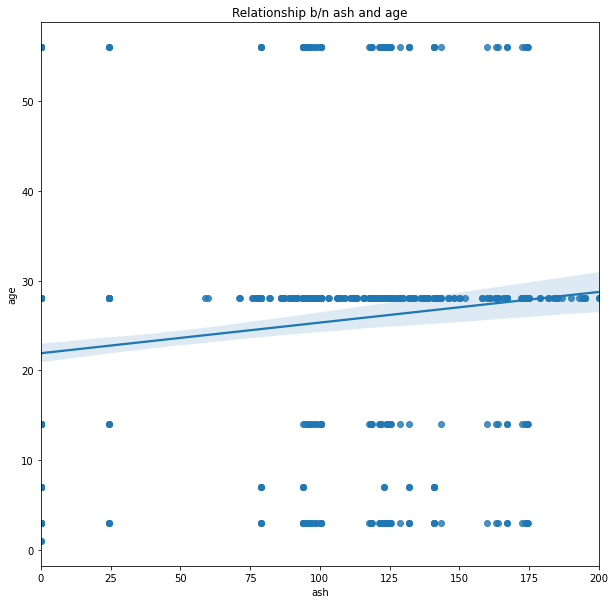

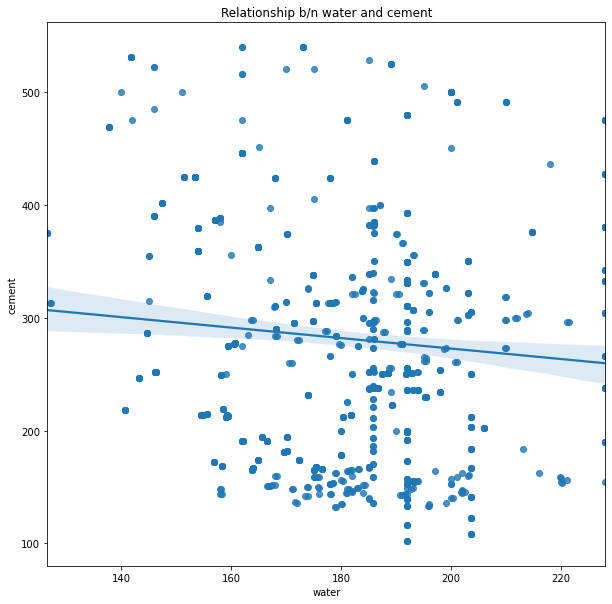

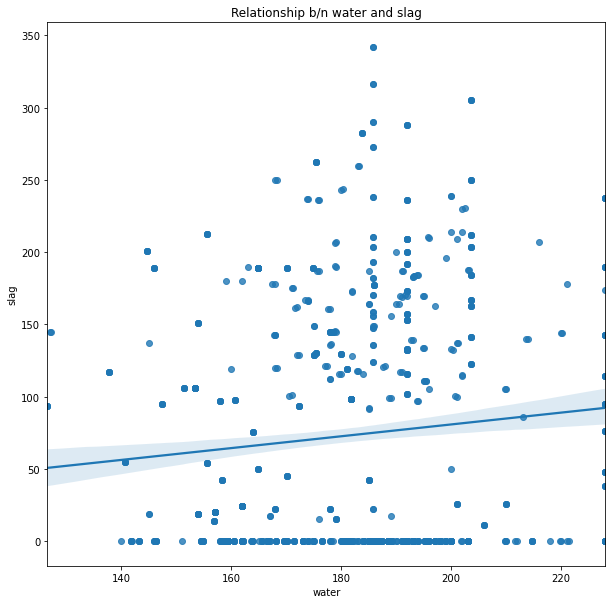

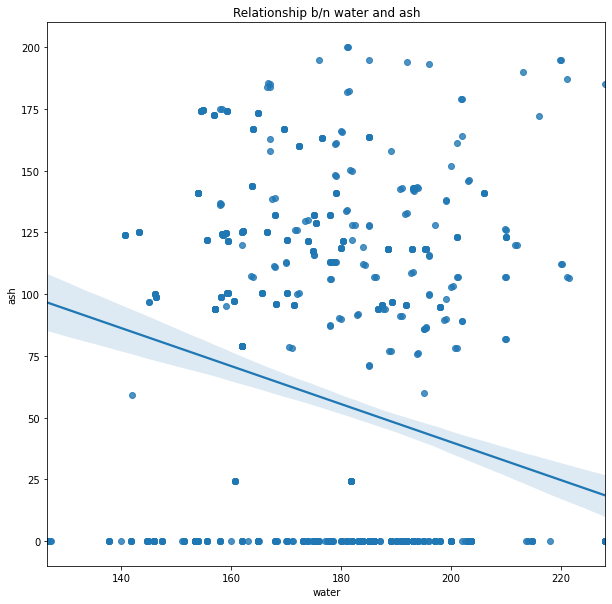

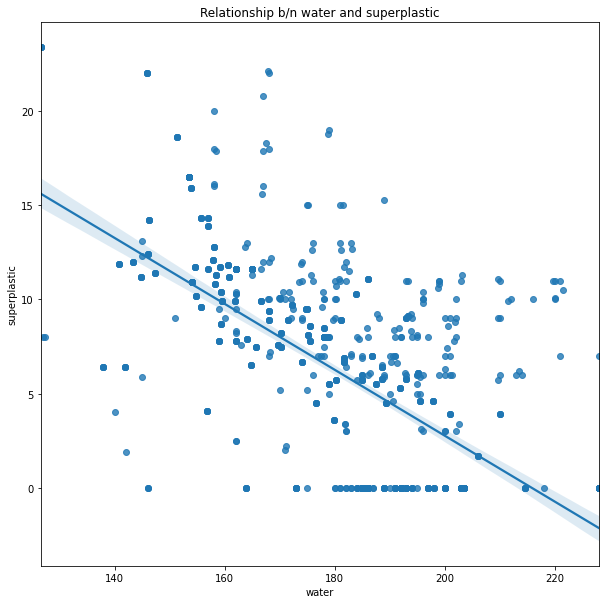

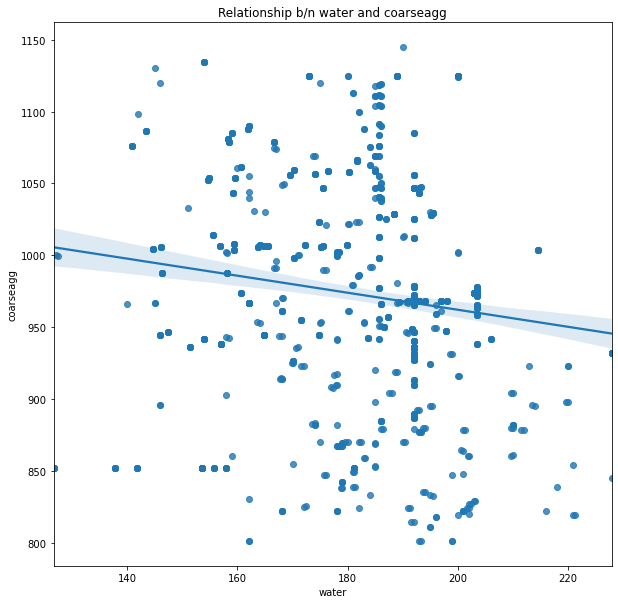

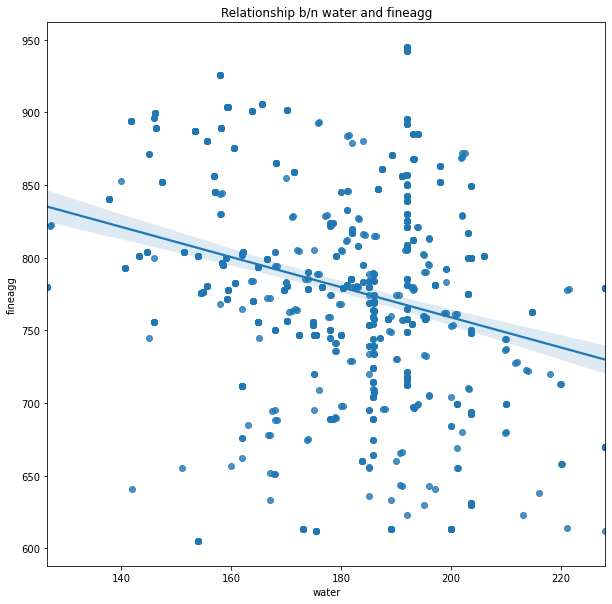

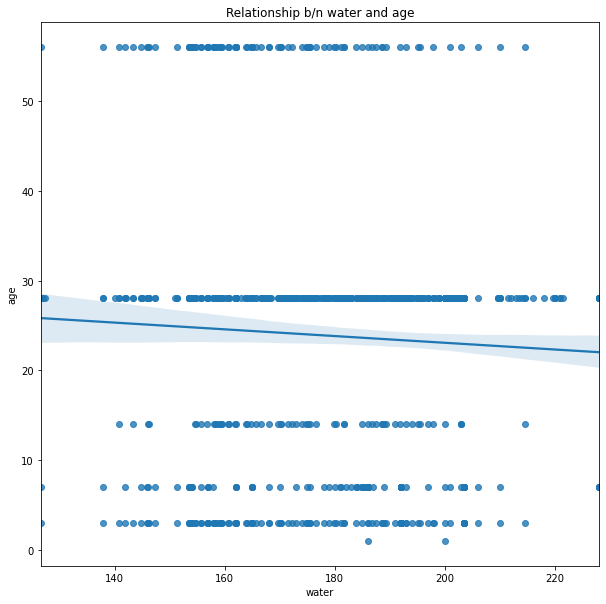

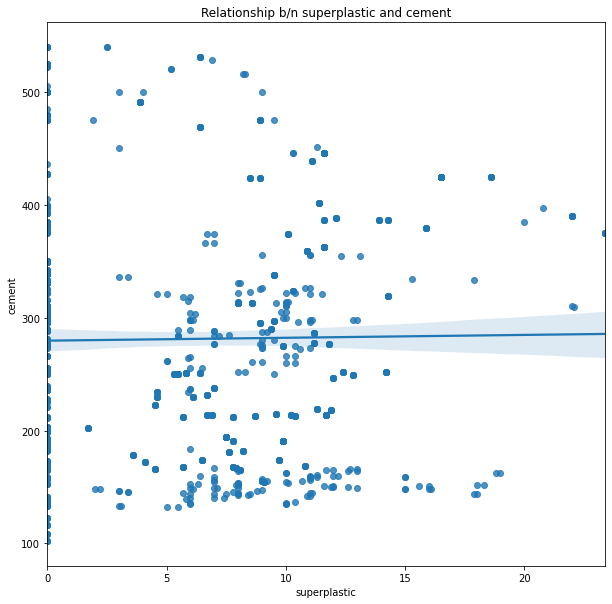

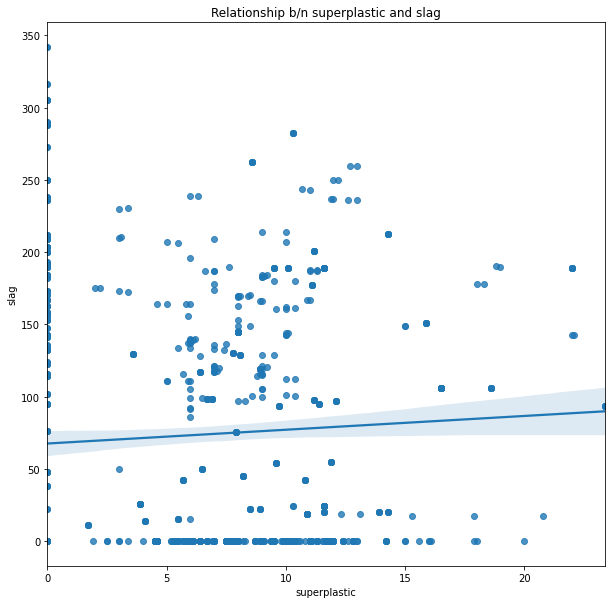

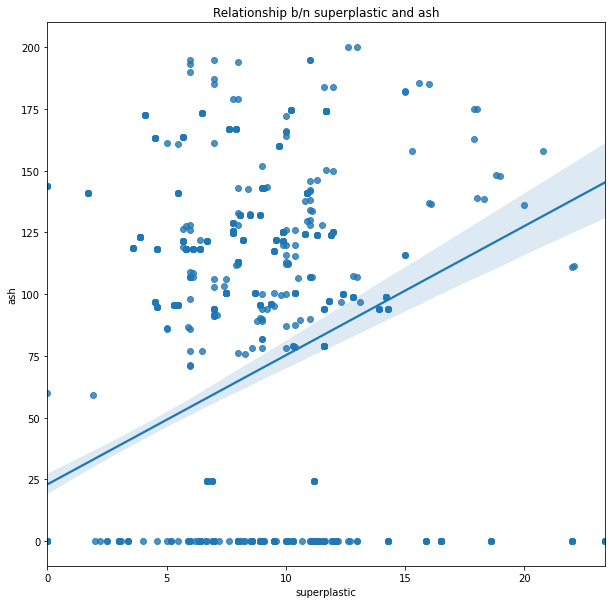

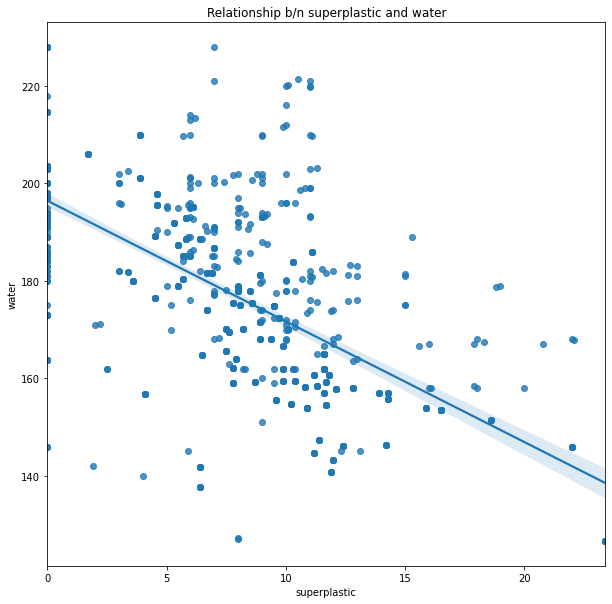

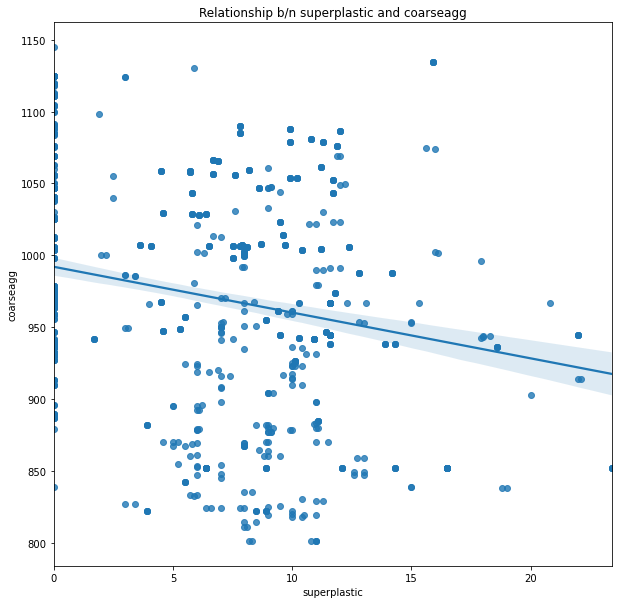

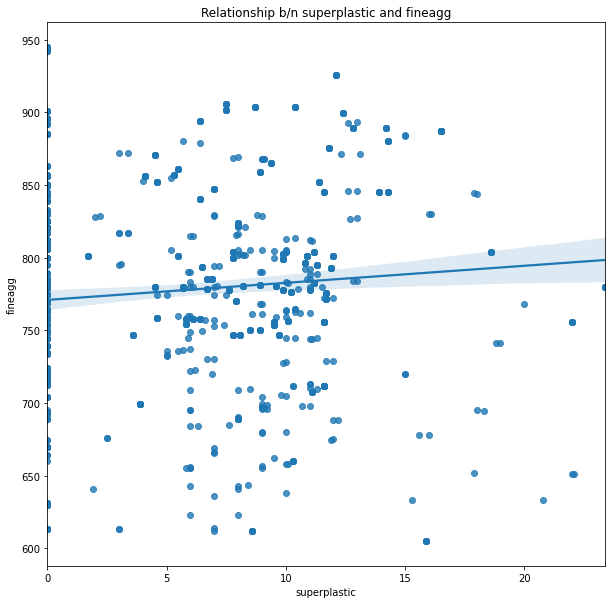

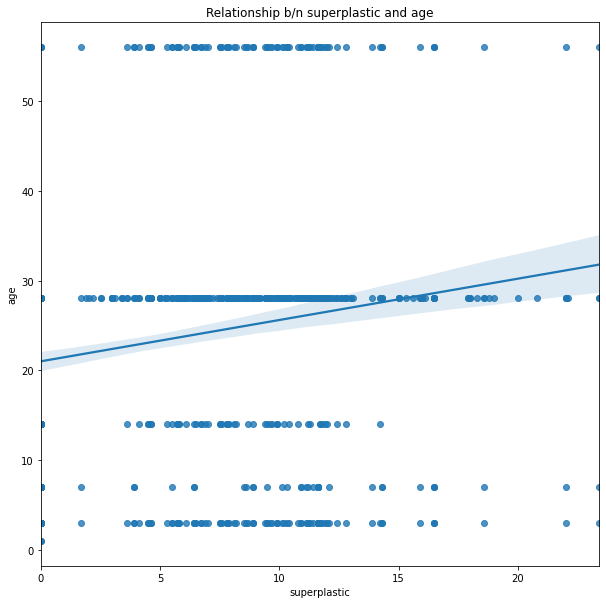

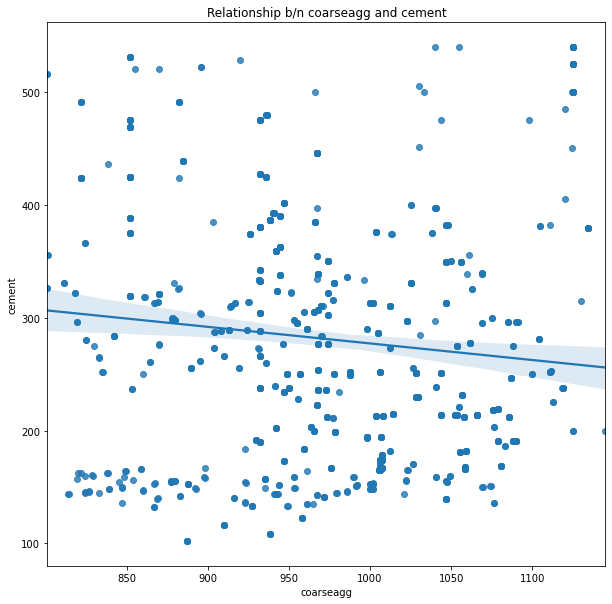

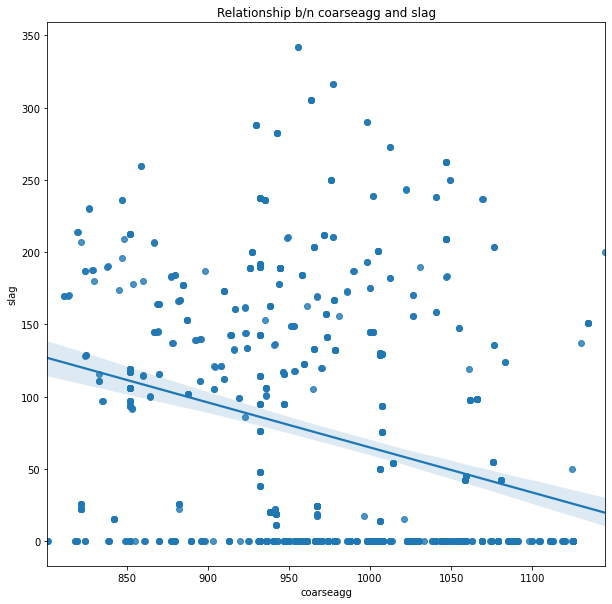

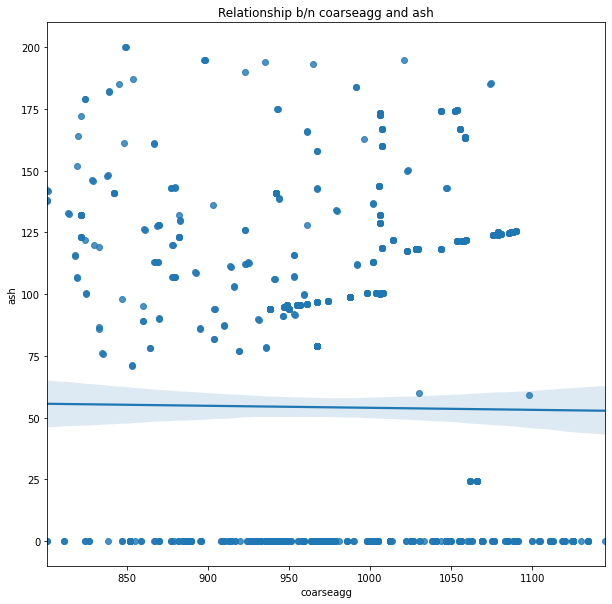

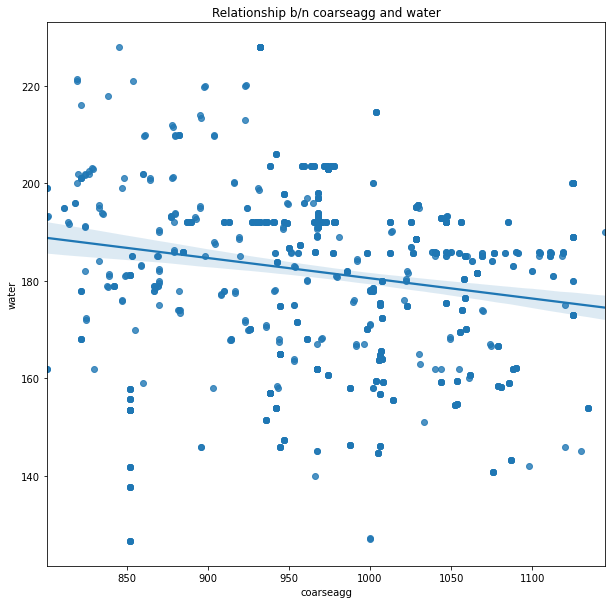

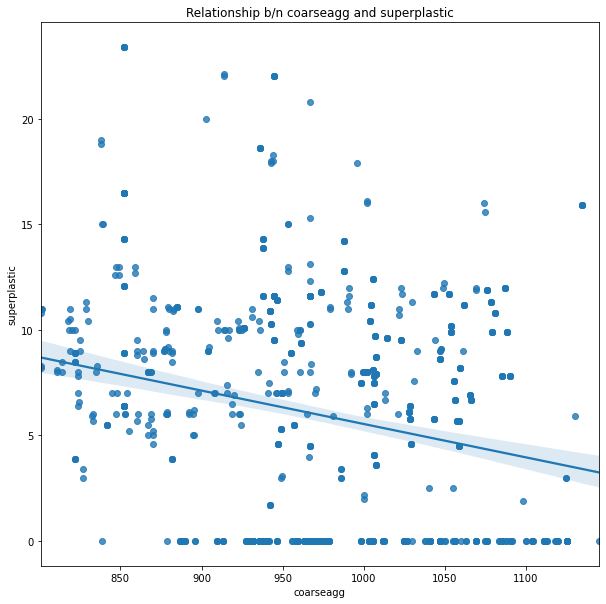

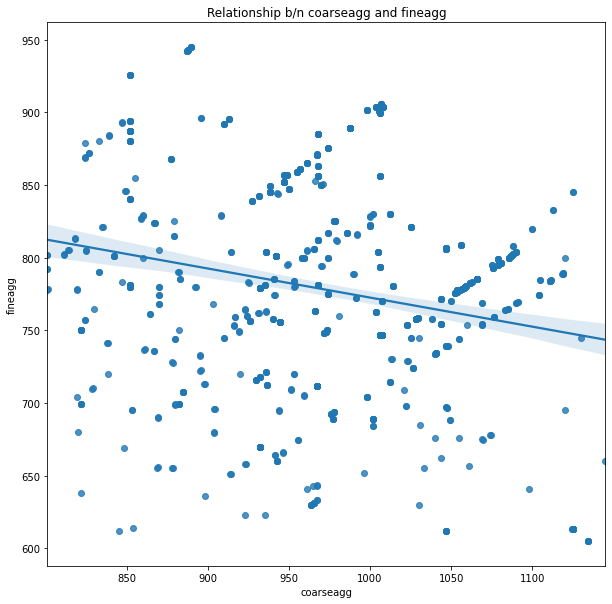

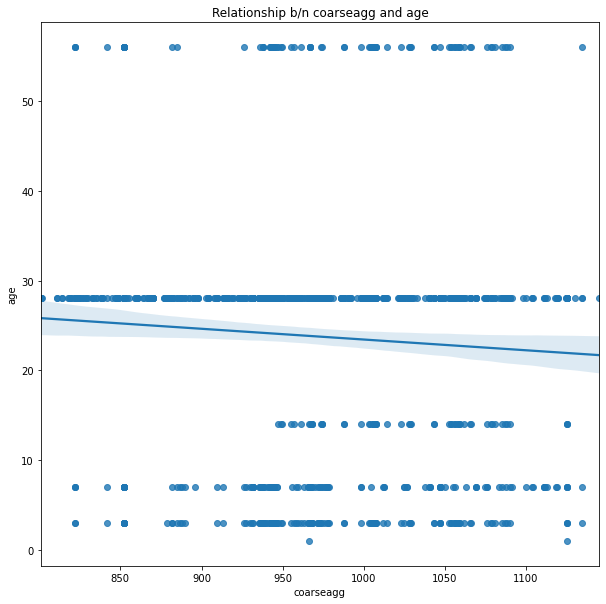

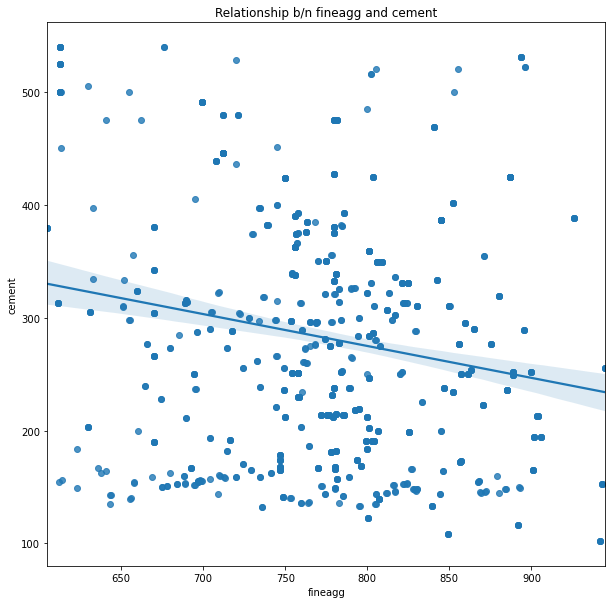

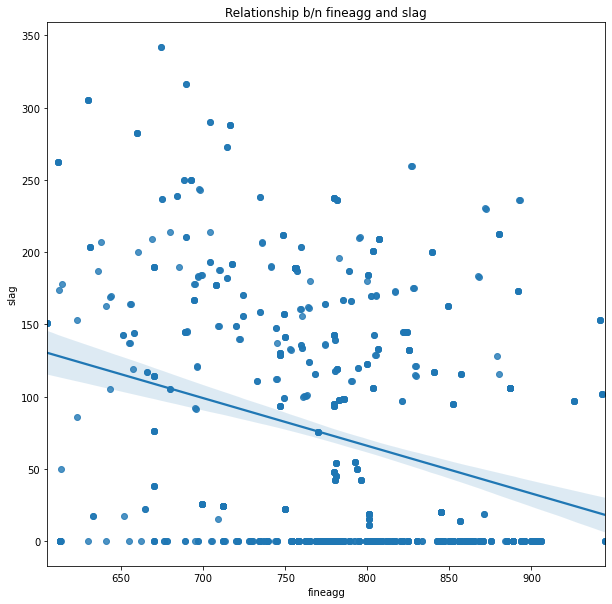

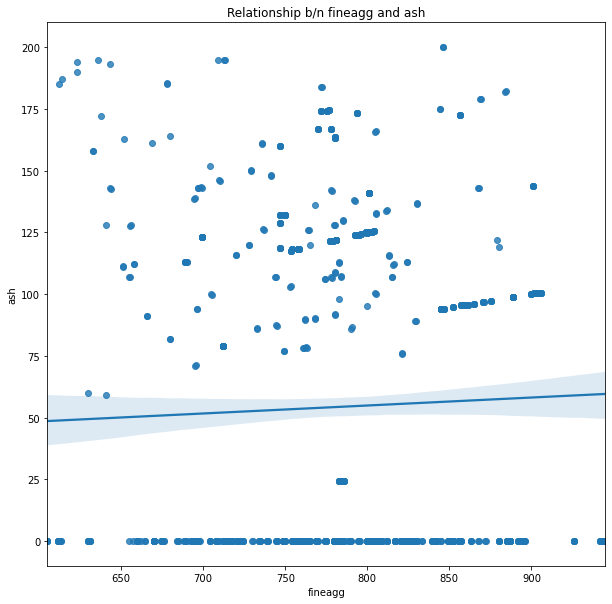

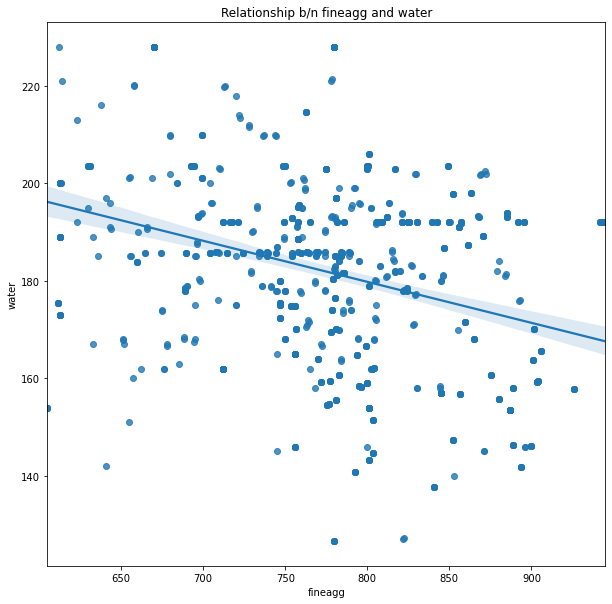

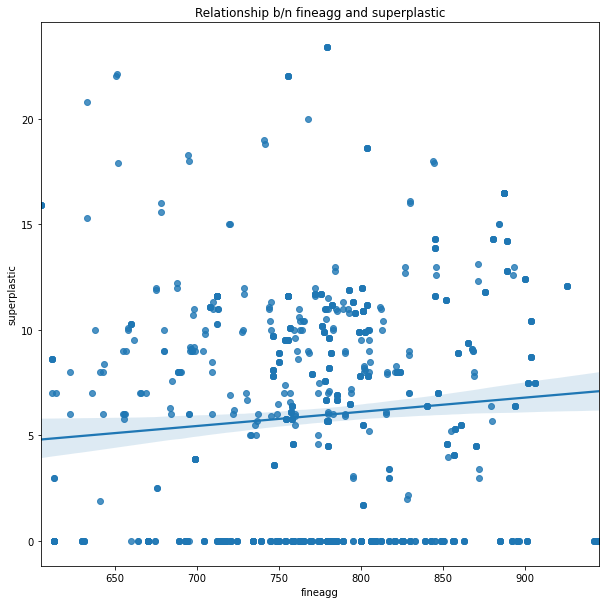

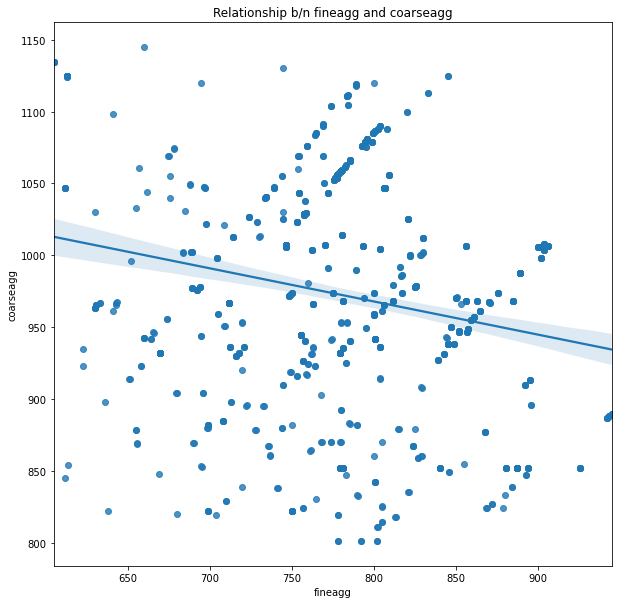

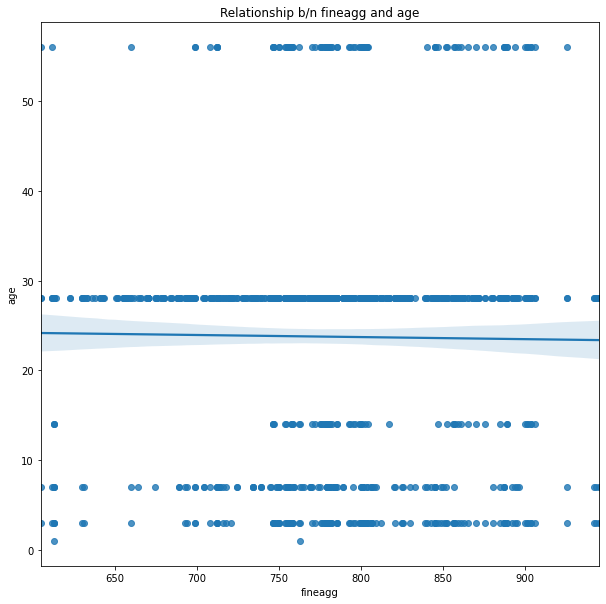

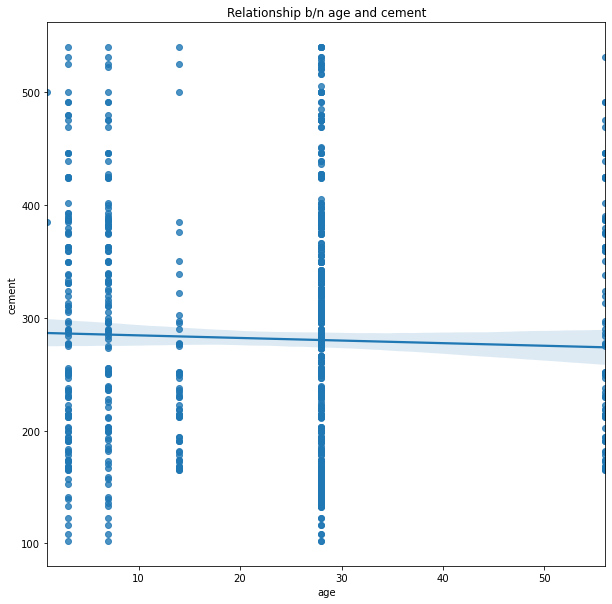

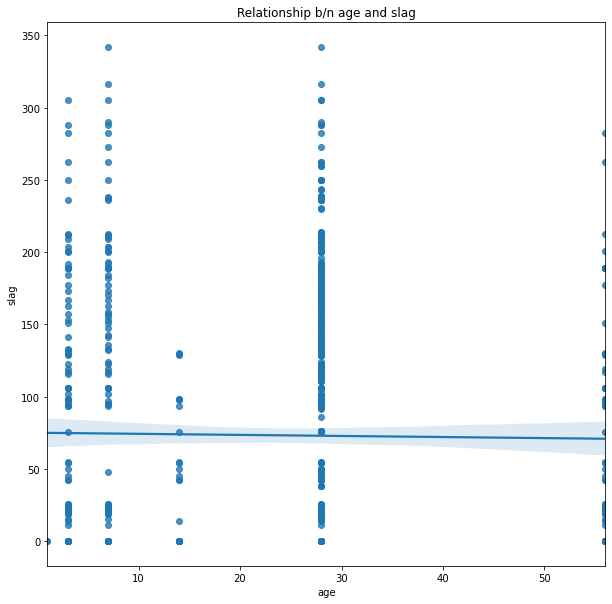

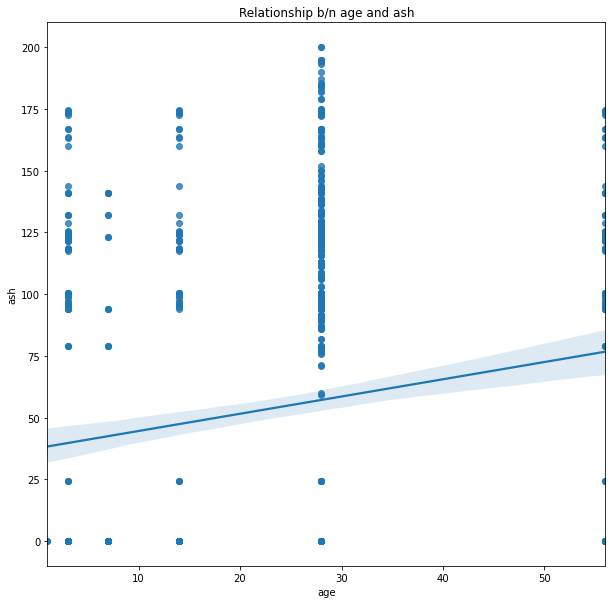

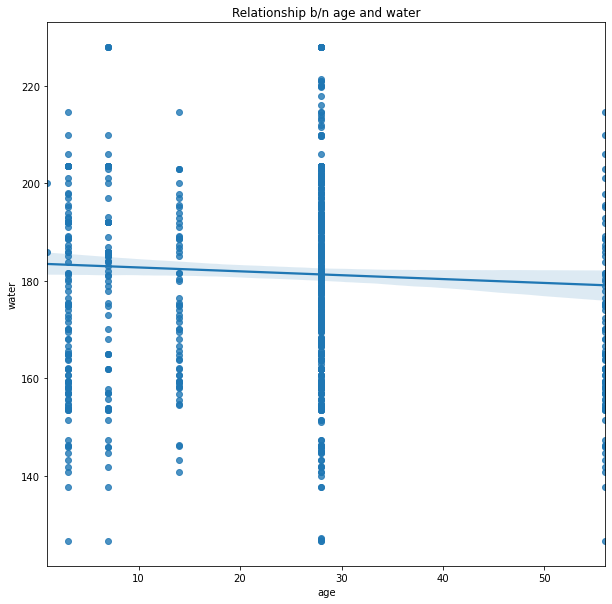

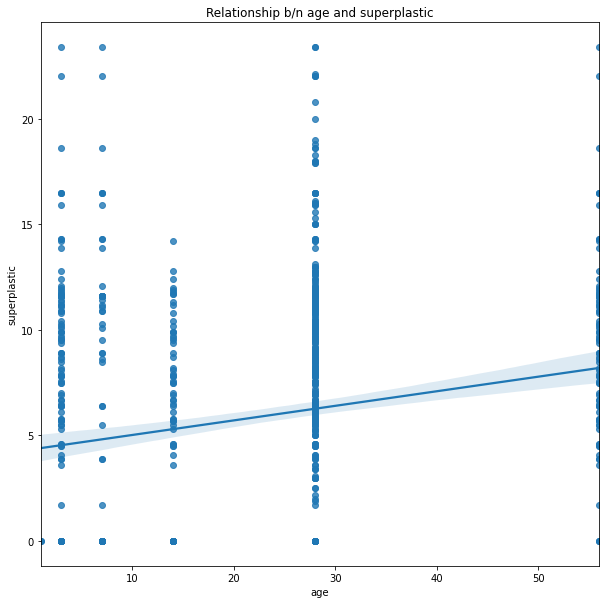

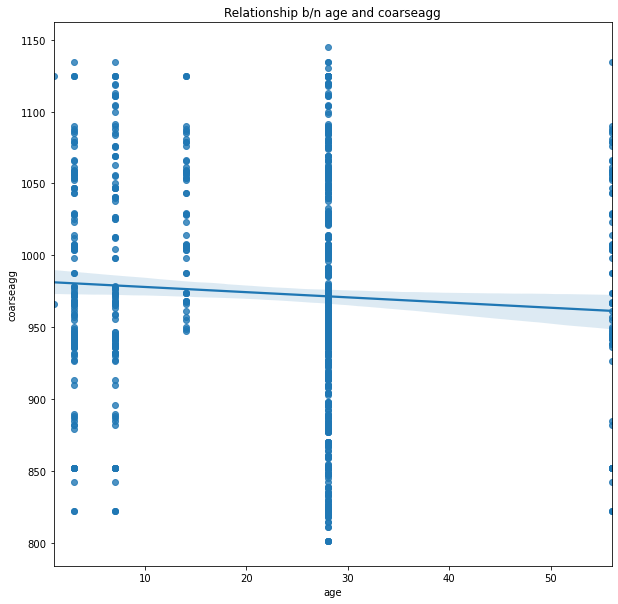

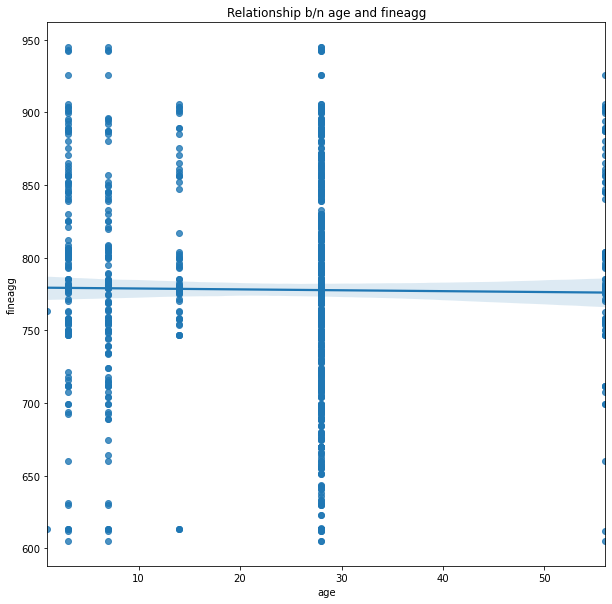

In [22]:
# Multivariet analysis
for col in list(x.columns):
    for  col2 in list(x.columns):
        if col != col2:
            fig,ax1 = plt.subplots(figsize=(10,10))
            sns.regplot(x=df[col],y=df[col2],ax=ax1).set_title(f'Relationship b/n {col} and {col2}')

# Checking for Mult-colinearity

In [23]:
# Checking for Mult-colinearity using correlation matrix
cor_mat = x.corr()
cor_mat

cement      slag       ash     water  superplastic  coarseagg  \
cement        1.000000 -0.275046 -0.397467 -0.091614      0.013336  -0.109349   
slag         -0.275046  1.000000 -0.320468  0.098880      0.061195  -0.283882   
ash          -0.397467 -0.320468  1.000000 -0.248011      0.447492  -0.009961   
water        -0.091614  0.098880 -0.248011  1.000000     -0.658056  -0.156928   
superplastic  0.013336  0.061195  0.447492 -0.658056      1.000000  -0.224503   
coarseagg    -0.109349 -0.283882 -0.009961 -0.156928     -0.224503   1.000000   
fineagg      -0.195751 -0.279763  0.036516 -0.295604      0.088840  -0.214815   
age          -0.031151 -0.012265  0.154224 -0.054536      0.178058  -0.065762   

               fineagg       age  
cement       -0.195751 -0.031151  
slag         -0.279763 -0.012265  
ash           0.036516  0.154224  
water        -0.295604 -0.054536  
superplastic  0.088840  0.178058  
coarseagg    -0.214815 -0.065762  
fineagg       1.000000 -0.011856  
age          -0.011856  1.000000

<AxesSubplot:>

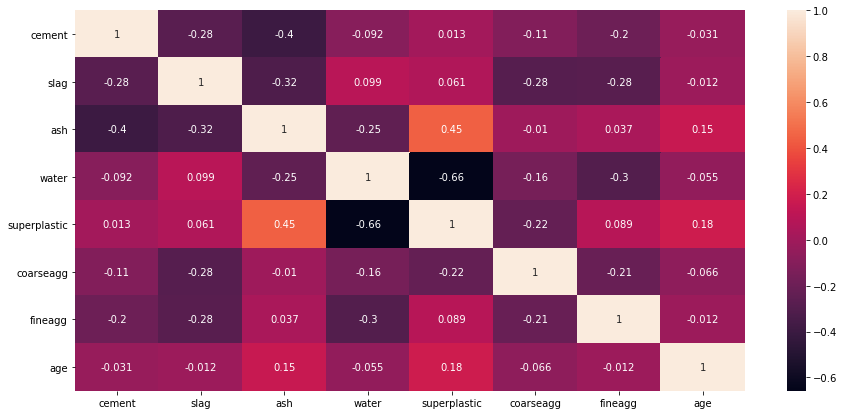

In [24]:
fig,ax = plt.subplots(figsize=(15,7))
sns.heatmap(cor_mat, annot=True)

#Checking collinearity using VIF(Variance Inflation Factor) method

In [25]:
def vifCollinearity(x):
    vif = pd.DataFrame()
    vif['feature_name'] = x.columns
    vif['vif_factor'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    return vif.sort_values(by='vif_factor',ascending=False).round(2)

In [26]:
vifCollinearity(x)

feature_name  vif_factor
3         water       90.61
5     coarseagg       82.33
6       fineagg       77.62
0        cement       14.17
4  superplastic        5.84
2           ash        4.45
7           age        4.00
1          slag        3.35

In [27]:
# Feature Dimensionality Reduction(PCA)
def applyPca(x):
    ncomponents = len(x.columns)
    #Scaling the data
    x = StandardScaler().fit_transform(x)
    #Applying PCA
    for i in range(1,ncomponents):
        pca = PCA(n_components=i)
        p_components = pca.fit_transform(x)
        exp_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        if exp_var_ratio[i-1] >= 0.99:
            ncomponents = i
            break
    print("Explained variance ratio after PCA is ", exp_var_ratio)
    
    #Creating DF of components
    col = []
    for i in range(1,ncomponents+1):
        col.append("PC" + str(i))
    p_comp = pd.DataFrame(data=p_components,columns=col)
    return p_comp

In [28]:
new_cell = applyPca(x)

Explained variance ratio after PCA is  [0.26283278 0.43990396 0.60204946 0.74443272 0.86947684 0.96977878
 0.99217605]


In [29]:
new_cell

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0    -1.773215  1.525052 -1.204041 -0.017545 -0.190572 -0.869984  0.074581
1     1.702733 -0.801671 -1.193574  0.370770 -1.368764  0.007398 -0.198836
2     0.705445 -0.455256 -0.518776 -1.071296  0.782878  0.062426 -0.112129
3    -2.621060  0.896098 -0.499096  0.522659  1.060508  0.493048 -0.398051
4    -0.777624  1.106570 -0.906785  1.323458 -0.772853 -0.827347 -1.012406
...        ...       ...       ...       ...       ...       ...       ...
1025  1.810870  0.043005 -1.549076 -0.265265  0.501270  0.672689 -0.194472
1026  0.756860 -1.052132  3.301696 -1.916591 -0.767186  0.500163  0.981117
1027  0.625393  1.268950  0.328922 -0.068809  0.423475  0.583748  0.289968
1028 -2.548765  0.054110  0.037095  0.501070  1.514181  0.814546 -0.468693
1029 -1.922648 -2.703795  1.372456  2.242855 -0.889332  0.587436  0.582273

[1030 rows x 7 columns]

In [30]:
vifCollinearity(new_cell)

feature_name  vif_factor
1          PC2         1.0
3          PC4         1.0
0          PC1         1.0
2          PC3         1.0
4          PC5         1.0
5          PC6         1.0
6          PC7         1.0

Model Building

In [31]:
#train-test split
def trainTestSplit(x,y,testSize=0.3):
    return train_test_split(x,y,test_size=testSize,random_state=50)

In [32]:
#Building and fitting models
def modelBuilding(modelName,model,x,y,testSize=0.3):
    x_train, x_test, y_train, y_test = trainTestSplit(x,y)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2_value = r2_score(y_test,y_pred)*100
    li = [modelName,r2_value,rmse]
    return li

In [33]:
#Building all the models
def buildModels(x,y):
    col_names = ['Model_name','R-sqr','RMSE']
    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)]=modelBuilding('LinearRegression',LinearRegression(),x,y)
    result.loc[len(result)]=modelBuilding('Lasso',Lasso(),x,y)
    result.loc[len(result)]=modelBuilding('Ridge',Ridge(),x,y)
    result.loc[len(result)]=modelBuilding('DecisionTreeRegressor',DecisionTreeRegressor(),x,y)
    result.loc[len(result)]=modelBuilding('AdaBoostRegressor',AdaBoostRegressor(),x,y)
    result.loc[len(result)]=modelBuilding('RandomForestRegressor',RandomForestRegressor(),x,y)
    result.loc[len(result)]=modelBuilding('GradientBoostingRegressor',GradientBoostingRegressor(),x,y)
    result.loc[len(result)]=modelBuilding('SVR',SVR(),x,y)
    result.loc[len(result)]=modelBuilding('KNeighborsRegressor',KNeighborsRegressor(),x,y)
    return result

In [34]:
output = buildModels(new_cell,y)

In [35]:
output

Model_name      R-sqr       RMSE
0           LinearRegression  68.062382   9.412190
1                      Lasso  63.525408  10.058533
2                      Ridge  68.059185   9.412661
3      DecisionTreeRegressor  69.335056   9.222752
4          AdaBoostRegressor  64.389743   9.938641
5      RandomForestRegressor  78.970101   7.637620
6  GradientBoostingRegressor  77.162103   7.959165
7                        SVR  65.244129   9.818689
8        KNeighborsRegressor  73.263067   8.611826

In [36]:
## cross validation
def kFoldCv(x,y,folds=10):
    lr= LinearRegression()
    lasso = Lasso()
    ridge = Ridge()
    dt = DecisionTreeRegressor()
    ada = AdaBoostRegressor()
    rf = RandomForestRegressor()
    gbr = GradientBoostingRegressor()
    svr =SVR()
    knn = KNeighborsRegressor()
    
    #scoring using cross validation
    score_lr = cross_val_score(lr,x,y,cv=folds)
    score_lasso = cross_val_score(lasso,x,y,cv=folds)
    score_ridge = cross_val_score(ridge,x,y,cv=folds)
    score_dt = cross_val_score(dt,x,y,cv=folds)
    score_ada = cross_val_score(ada,x,y,cv=folds)
    score_rf = cross_val_score(rf,x,y,cv=folds)
    score_gbr = cross_val_score(gbr,x,y,cv=folds)
    score_svr = cross_val_score(svr,x,y,cv=folds)
    score_knn = cross_val_score(knn,x,y,cv=folds)
    
    #building output frame
    models = [lr,lasso,ridge,dt,ada,rf,gbr,svr,knn]
    model_names = ['LR','Lasso','Ridge','DT','ADA','RF','GB','SVR','KNN']
    scores = [score_lr,score_lasso,score_ridge,score_dt,score_ada,score_rf,score_gbr,score_svr,score_knn]
    
    result = []
    for idx in range(0,len(models)):
        score_mean = round(np.mean(scores[idx])*100,2)
        score_std = np.std(scores[idx])
        m_name = model_names[idx]
        temp = [m_name,score_mean,score_std]
        result.append(temp)
    result_df = pd.DataFrame(result,columns=['Model_name','Average_accuracy','Accuracy_Stdev'])
    return result_df
    

In [37]:
kFoldCv(x,y)

Model_name  Average_accuracy  Accuracy_Stdev
0         LR             67.50        0.054527
1      Lasso             67.56        0.054775
2      Ridge             67.50        0.054527
3         DT             76.50        0.067153
4        ADA             70.87        0.048874
5         RF             83.35        0.046578
6         GB             82.91        0.045219
7        SVR             20.22        0.041140
8        KNN             58.88        0.067096

Cluster Analysis

In [38]:
x = df2.drop('strength',axis = 1)

In [39]:
y = df2[['strength']]

In [40]:
from sklearn.cluster import KMeans

<AxesSubplot:xlabel='cement', ylabel='strength'>

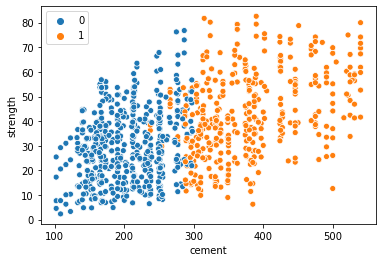

In [41]:
labels = KMeans(n_clusters=2, random_state=100).fit_predict(x)
sns.scatterplot(df2.cement,df2.strength,hue = labels)

In [42]:
# Plotting clusters between the variables
def KMeansPlot(x,t_col,labels):
    columns = list(set(list(x.columns))-set([t_col]))   # prevents clustering between same variables
    r = int(len(columns)/2)
    if r%2 ==0:
        r=r
    else:
        r = r+1
        
    #plotting cluster plots
    f,ax = plt.subplots(r,2,figsize=(15,15))
    a = 0
    for col in range(0,r):
        for j in range(0,2):
            if a!= len(columns):
                ax[col][j].scatter(x[t_col],x[columns[a]],c = labels)
                ax[col][j].set_xlabel(t_col)
                ax[col][j].set_ylabel(columns[a])
                a = a+1
                

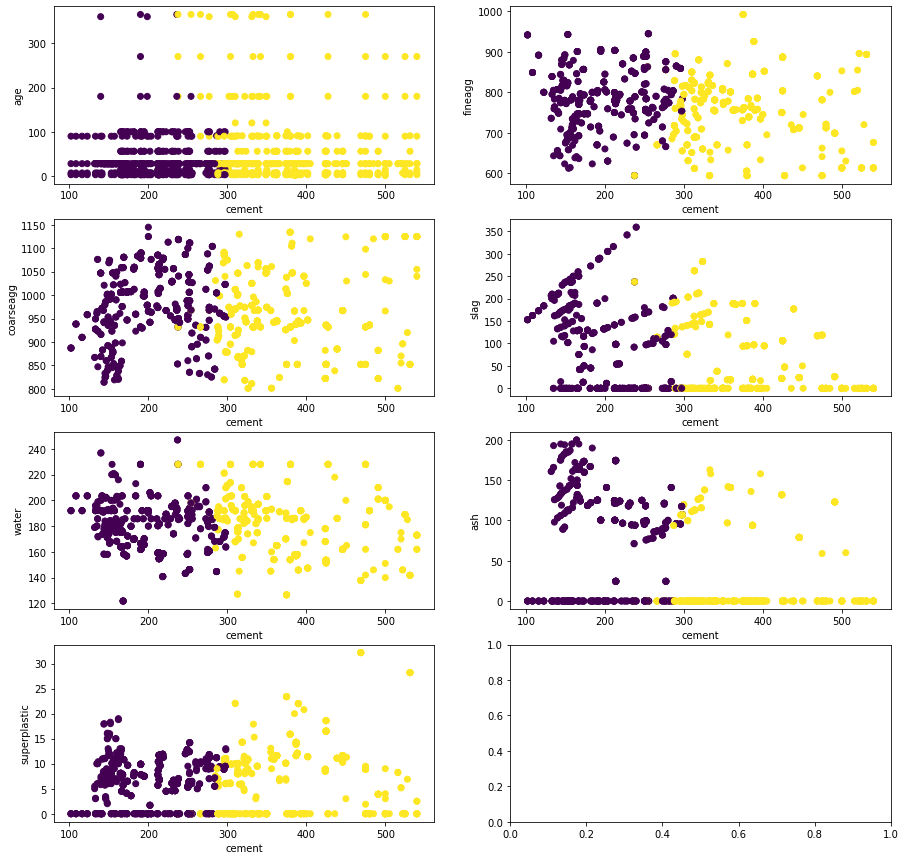

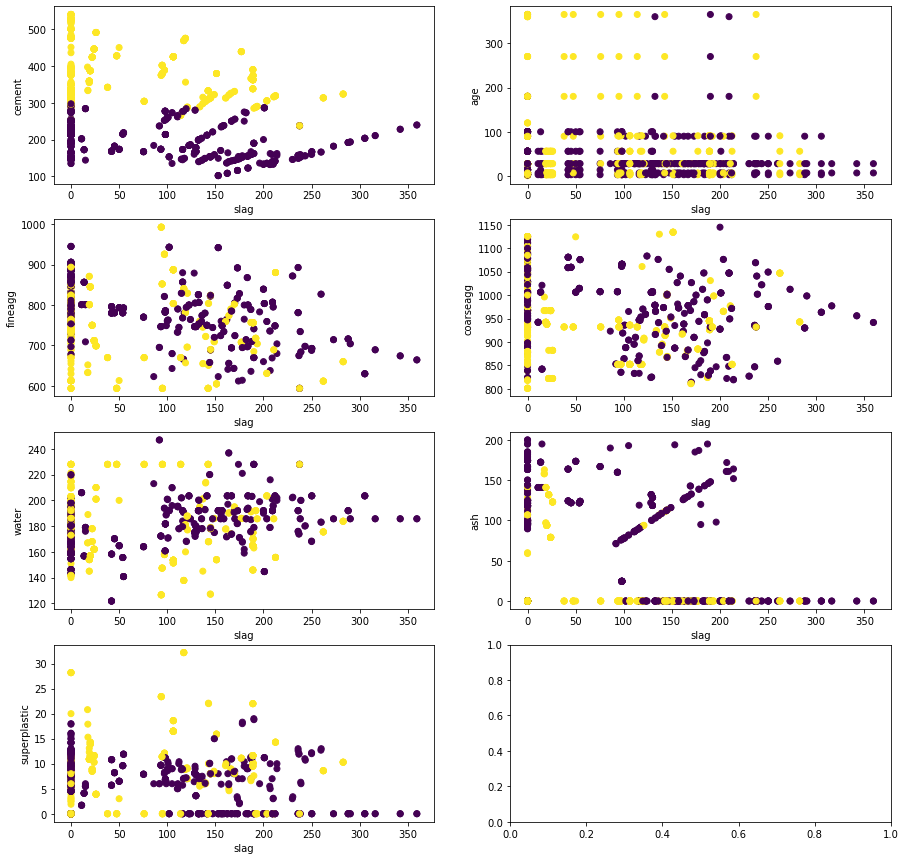

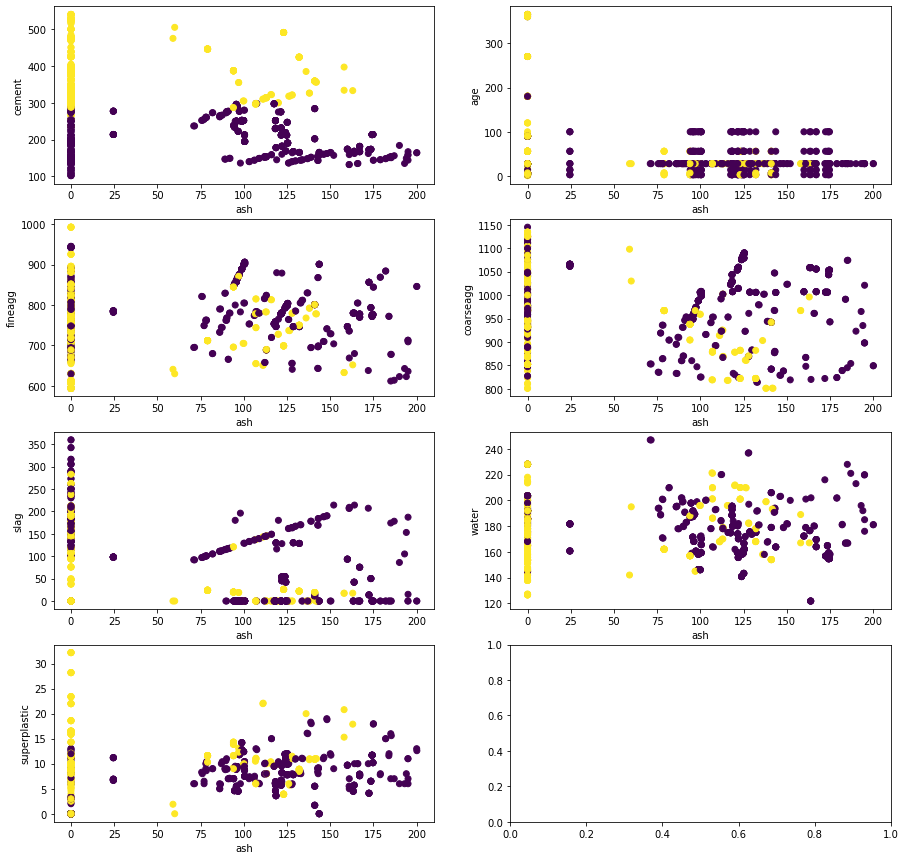

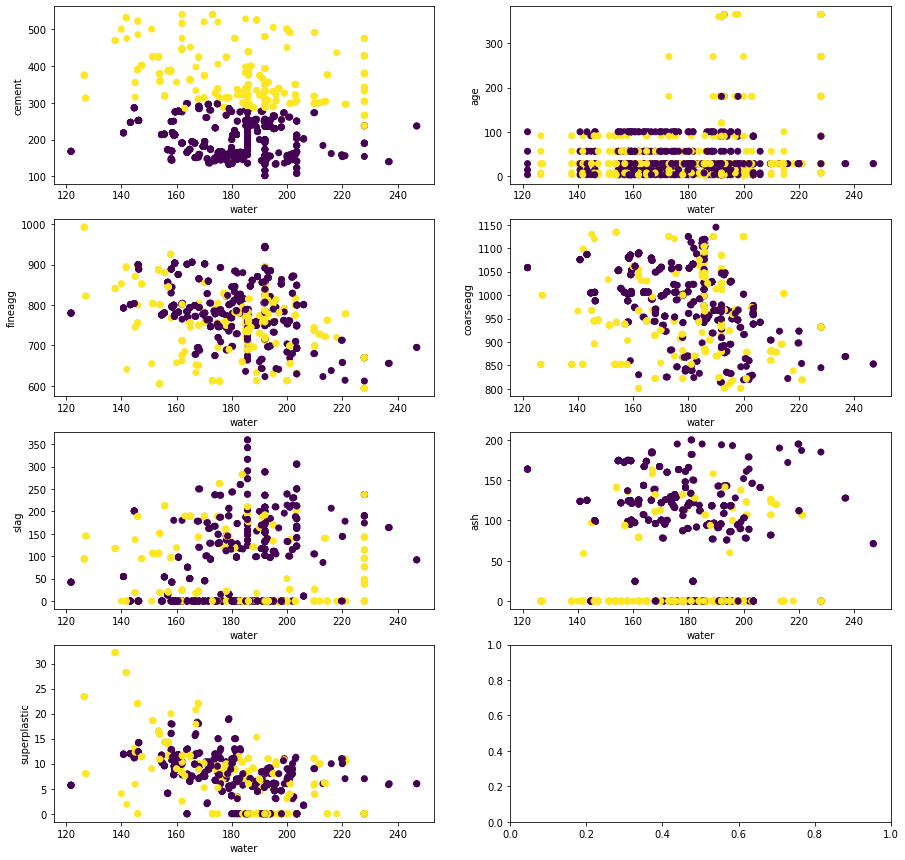

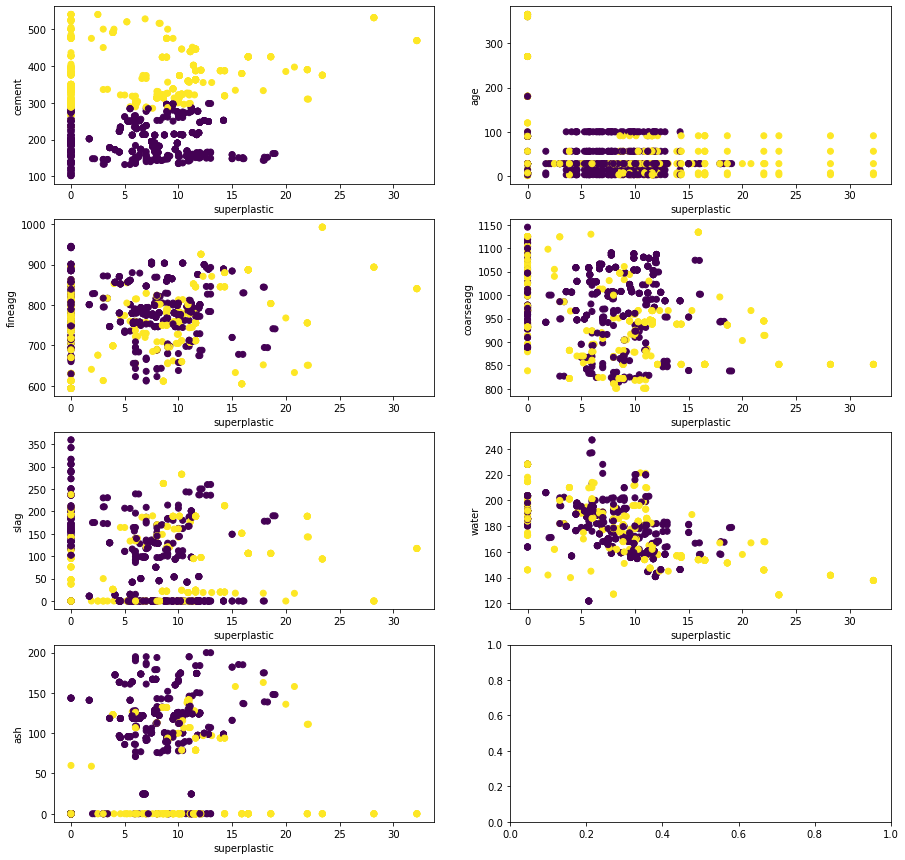

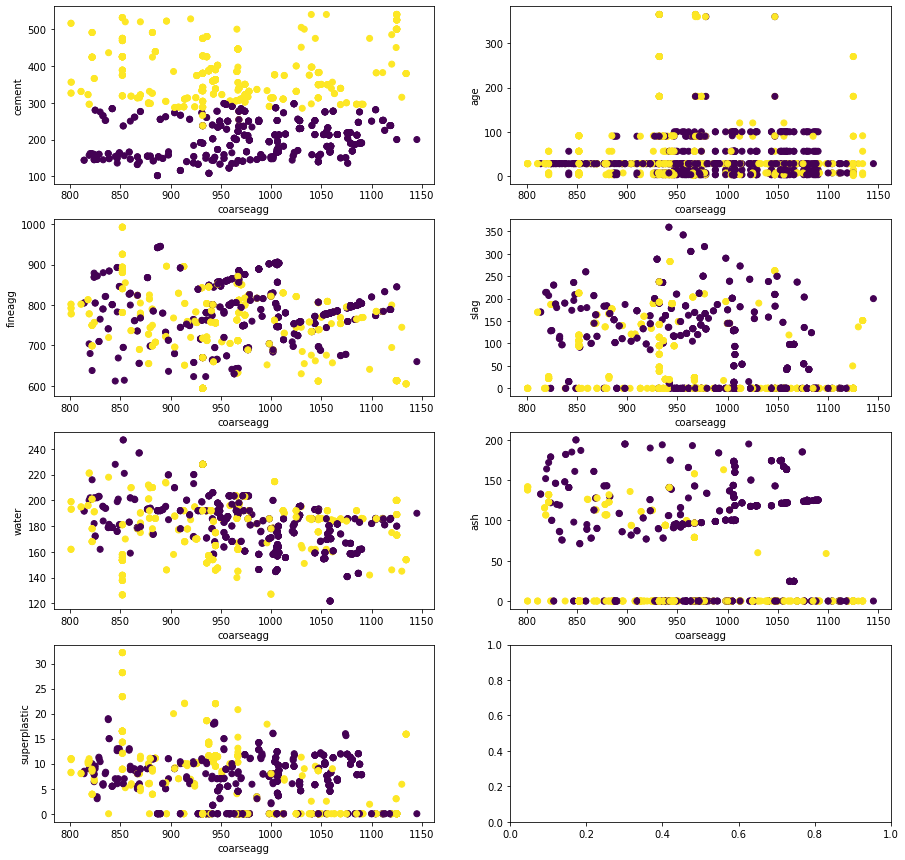

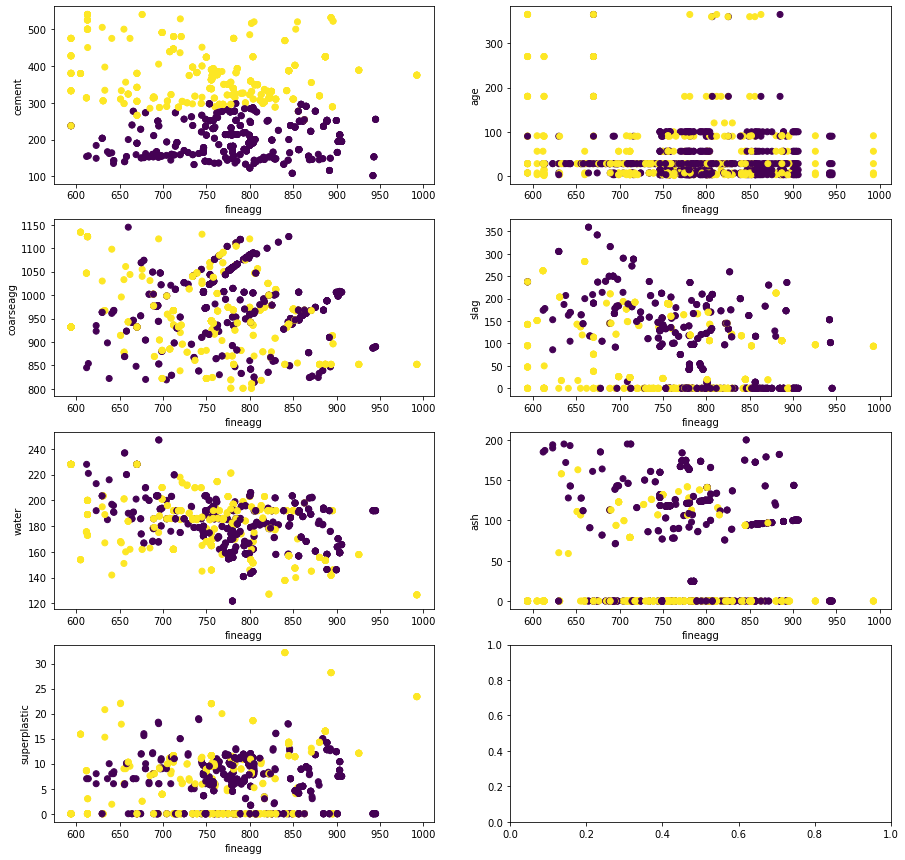

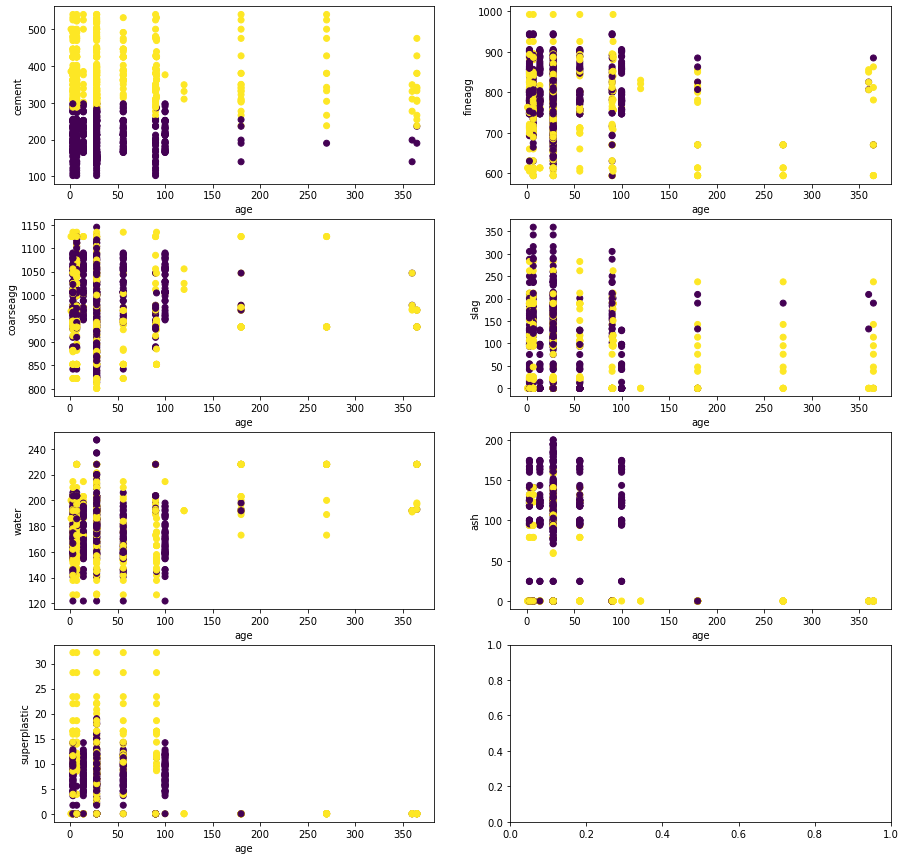

In [43]:
for col in x.columns:
    KMeansPlot(x,col,labels)